https://github.com/fedecaselli

To run this notebook, please first decompress '2011-capitalbikeshare-tripdata.csv.zip' and '2012-capitalbikeshare-tripdata.zip'

# Bike Rental Count Prediction

In [7818]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
import os
import statsmodels.api as sm
from itertools import combinations

## 1. EDA

In [7819]:
df = pd.read_csv('bike+sharing+dataset/hour.csv')
df.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### General Information

Brief Features' Description

    Categorical Features:

Season: 1: winter, 2: spring, 3: summer, 4: fall 

Year: Year (0: 2011, 1: 2012) 

Month: Month (1 to 12) 

Hour: Hour (0 to 23) 

Holiday: Whether the day is a holiday 

Weekday: Day of the week (0-6)

WorkingDay: If the day is neither weekend nor holiday: 1, otherwise: 0

Weather Situation: 1: Clear, Few clouds, Partly cloudy, 2: Mist + cloudy, 3: Light snow/rain

    Numerical Features: 

Instant: Record index 

dteday:

temp: Normalized temperature in Celsius, range: [–8, +39]

atemp: Normalized feeling temperature in Celsius, range: [–16, +50]

hum: Normalized humidity, values divided by 100

windspeed: Normalized wind speed, values divided by 67

casual: count of casual users

registered: count of registered users


In [7820]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [7821]:
df.describe()


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [7822]:
df.nunique()

instant       17379
dteday          731
season            4
yr                2
mnth             12
hr               24
holiday           2
weekday           7
workingday        2
weathersit        4
temp             50
atemp            65
hum              89
windspeed        30
casual          322
registered      776
cnt             869
dtype: int64

### Missing Values

In [7823]:
df.isnull()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
17375,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
17376,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
17377,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


The daset contains 17379 entries and 17 features representing the hourly bike rental data for the years 2011 and 2012. 

Despite there are no null values and apparently no placeholders, the expected count of records will be compared to the actual number of records in the dataset, as the number of entries could be incomplete.

The following code will check the number of days per year and calculate the total expected records.

In [7824]:
# Define the years you are working with
years = [2011, 2012]

# Dictionary to store expected records per year
expected_records_per_year = {}

# Calculate expected records for each year
for year in years:
    # Determine if the year is a leap year
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        days_in_year = 366
    else:
        days_in_year = 365
    
    # Calculate the expected records for the year
    expected_records_per_year[year] = days_in_year * 24  # 24 hours per day

# Print the expected records for each year
for year, expected_records in expected_records_per_year.items():
    print(f"Expected number of records for {year}: {expected_records}")

# Calculate total expected records across all years
total_expected_records = sum(expected_records_per_year.values())
print(f"\nTotal expected records for both years: {total_expected_records}")


Expected number of records for 2011: 8760
Expected number of records for 2012: 8784

Total expected records for both years: 17544


Since the expected records is 17544 and the actual records in the dataset are 17379, missing records will now be identified by full date (year-month-day hr:min:sec)

In [7825]:
# Create a full date-time index for all expected hours between 2011 and 2012
df_copy = df.copy()

start_date = datetime(2011, 1, 1, 0)
end_date = datetime(2012, 12, 31, 23)
full_datetime_index = pd.date_range(start=start_date, end=end_date, freq='h') 

# Convert 'dteday' and 'hr' to a comparable datetime index in the copied DataFrame
df_copy['datetime'] = pd.to_datetime(df_copy['dteday'].astype(str) + ' ' + df_copy['hr'].astype(str) + ':00:00')

# Find the missing records by comparing expected index with actual records
actual_index = pd.Index(df_copy['datetime'])
missing_dates = full_datetime_index.difference(actual_index)

# Display missing dates
print(f"Total missing records: {len(missing_dates)}")
print("\nMissing records (showing first 20):")
print(missing_dates[:20])

pd.DataFrame(missing_dates, columns=['datetime']).to_csv('missing_dates.csv', index=False)

Total missing records: 165

Missing records (showing first 20):
DatetimeIndex(['2011-01-02 05:00:00', '2011-01-03 02:00:00',
               '2011-01-03 03:00:00', '2011-01-04 03:00:00',
               '2011-01-05 03:00:00', '2011-01-06 03:00:00',
               '2011-01-07 03:00:00', '2011-01-11 03:00:00',
               '2011-01-11 04:00:00', '2011-01-12 03:00:00',
               '2011-01-12 04:00:00', '2011-01-14 04:00:00',
               '2011-01-18 00:00:00', '2011-01-18 01:00:00',
               '2011-01-18 02:00:00', '2011-01-18 03:00:00',
               '2011-01-18 04:00:00', '2011-01-18 05:00:00',
               '2011-01-18 06:00:00', '2011-01-18 07:00:00'],
              dtype='datetime64[ns]', freq=None)


In [7826]:
percentage_missing_records = len(missing_dates)/len(df) * 100
print(percentage_missing_records)

0.9494217158639737


In [7827]:
#We will also be adding it to the dataset as it will be later used 
df['datetime'] = pd.to_datetime(df['dteday'].astype(str) + ' ' + df['hr'].astype(str) + ':00:00')

In [7828]:
missing_df = pd.DataFrame(missing_dates, columns=['datetime'])

missing_df['year'] = missing_df['datetime'].dt.year

# Count missing records by year
missing_count_by_year = missing_df['year'].value_counts().sort_index()

# Display results
print("Missing Records by Year:")
print(missing_count_by_year)

Missing Records by Year:
year
2011    115
2012     50
Name: count, dtype: int64


Our next step is to identify the missing records and determine if they are randomly distributed or correspond to specific days or periods.
It is now crucial to determine whether the missing entries are randomly distributed or if they are concentrated within specific time frames.

Randomly distributed missing entries could indicate data collection errors that are unlikely to introduce a systematic bias.

However, if the missing entries are concentrated within certain periods, such as entire days, weeks, or months, this could suggest more significant issues, leading to bias in model predictions. 

This will also help determine whether interpolation, imputation or exclusion should be applied.

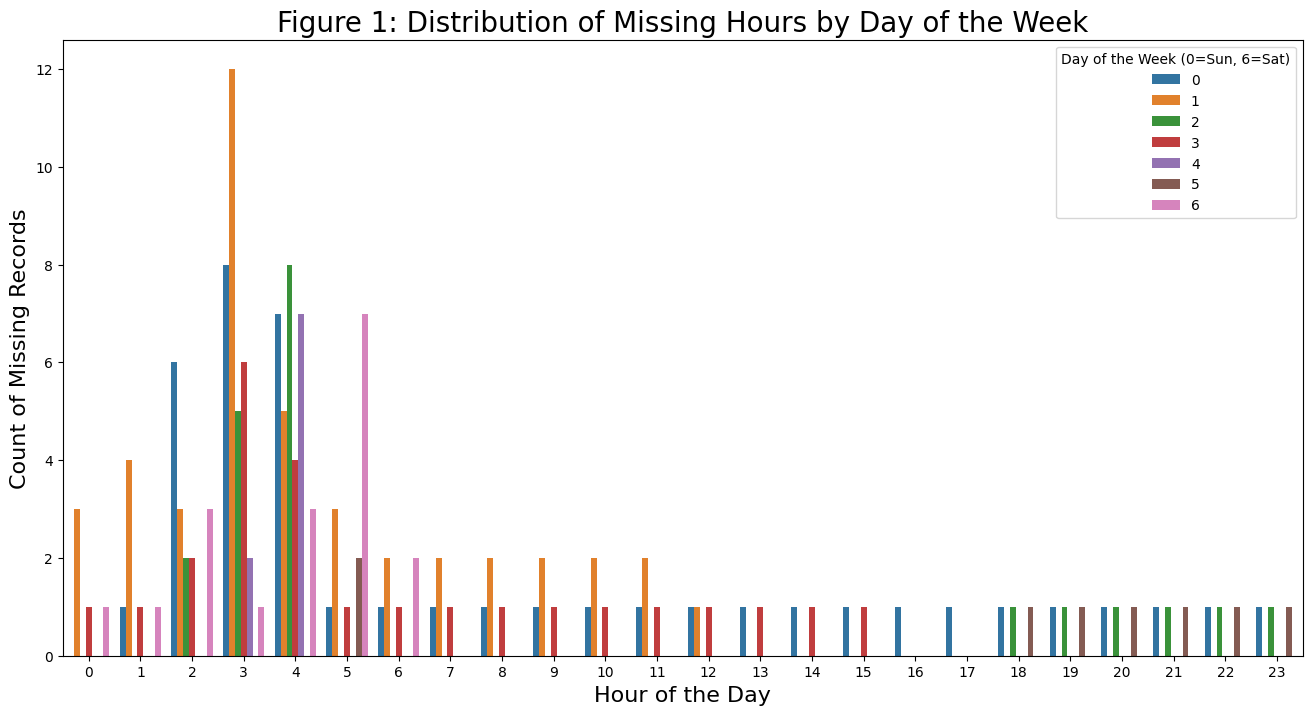

In [7829]:
# Extract hour and weekday from the 'datetime' column
missing_df['hour'] = missing_df['datetime'].dt.hour
missing_df['weekday'] = missing_df['datetime'].dt.weekday  # 0 = Sunday, 6 = Saturday

# Plot the distribution of missing hours for each day of the week
plt.figure(figsize=(16, 8))
sns.countplot(data=missing_df, x='hour', hue='weekday', palette='tab10')
plt.title('Figure 1: Distribution of Missing Hours by Day of the Week', fontsize=20)
plt.xlabel('Hour of the Day', fontsize=16)
plt.ylabel('Count of Missing Records', fontsize=16)
plt.legend(title='Day of the Week (0=Sun, 6=Sat)')
plt.show()


The majority of missing values are clustered between midnight and 6 am. Specially Mondays and Sundays have a high number of missing values in comparison to other days of the week. 

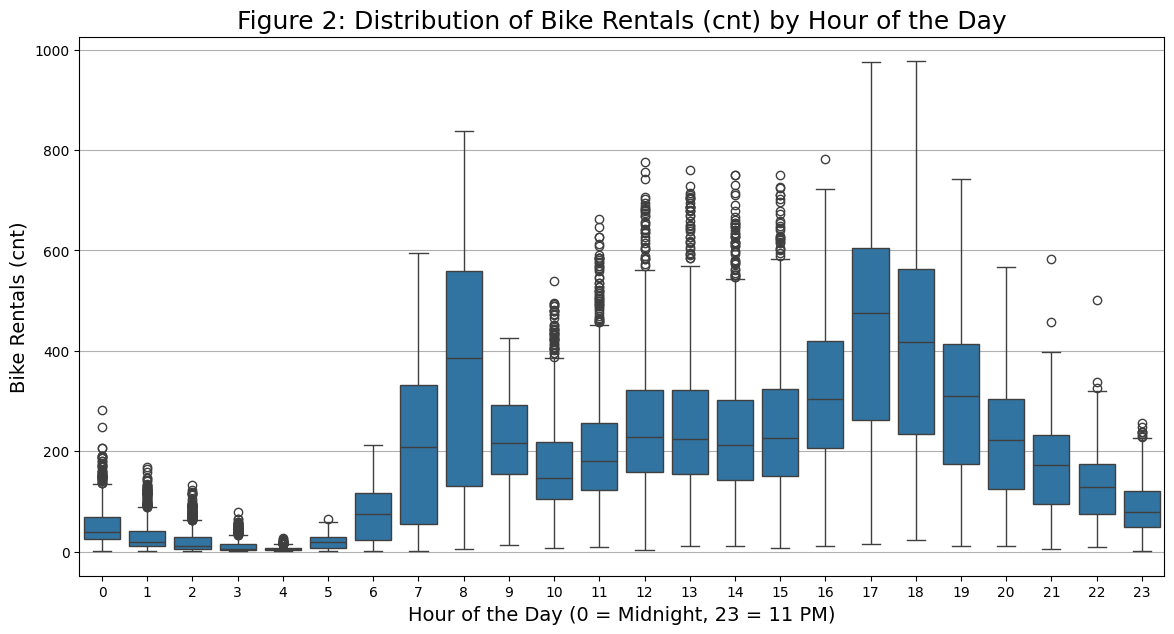

In [7830]:
# Plotting cnt by hr using a boxplot
plt.figure(figsize=(14, 7))
sns.boxplot(x='hr', y='cnt', data=df)
plt.title('Figure 2: Distribution of Bike Rentals (cnt) by Hour of the Day', fontsize=18)
plt.xlabel('Hour of the Day (0 = Midnight, 23 = 11 PM)', fontsize=14)
plt.ylabel('Bike Rentals (cnt)', fontsize=14)
plt.grid(True, axis='y')
plt.show()


The hours with most missing entries correspond to the hours with the lowest bike rental activity.
This suggests that the missing data may not significantly impact the prediction model, as those hours contribute less to the overall rental counts.
While it is possible that rental counts are low due to the missing entries, the fact that only 165 records are missing suggests that their inclusion would not drastically alter the overall distribution.

Given this information, the distribution of missing values does not appear to be completely random as they occur consistently during certain hours and specific days of the week.

Since the missing hours appear to be systematic, if the model is trained mostly on data from high-activity periods, it may fail to generalize well to low-activity periods, which could fail to generalize for low activity periods and perform poorly during those hours.

Ignoring these missing values could result in biased predictions, so entries may need to be filled.

Ignoring missing records as they are few, interpolation, using statistical values, will be considered

**Further Analysis**

Although the dataset indicates 165 missing records, during the transition from Standard Time to Daylight Saving Time in spring, one hour is effectively skipped, resulting in a lack of records for that specific hour. Conversely, during the transition from Daylight Saving Time to Standard Time in fall, an hour is repeated, which may appear as duplicate entries or cause inconsistencies in the dataset.

2011
https://www.timeanddate.com/time/change/usa?year=2011

Sunday, 13 March 2011, 02:00:00 clocks were turned forward 1 hour to Sunday, 13 March 2011, 03:00:00 local daylight time instead

Sunday, 6 November 2011, 02:00:00 clocks were turned backward 1 hour to Sunday, 6 November 2011, 01:00:00 local standard time instead

2012
https://www.timeanddate.com/time/change/usa?year=2012 

Sunday, 11 March 2012, 02:00:00 clocks were turned forward 1 hour to Sunday, 11 March 2012, 03:00:00 local daylight time instead

Sunday, 4 November 2012, 02:00:00 clocks were turned backward 1 hour to Sunday, 4 November 2012, 01:00:00 local standard time instead


Influence

Sunday 4 November 2011, 1 should appear twice / the information is recorded on the same hour

Sunday 6 November 2012, 1 should appear twice / the information is recorded on the same hour

Sunday, 13 March 2011, 2am should appear with 0 cnt or shouldnt appear

Sunday, 11 March 2012, 2am should appear with 0 cnt or shouldnt appear




In [7831]:
check_dates = {
    '2011-03-13': 2,   
    '2012-03-11': 2,   
    '2011-11-06': 2,  
    '2012-11-04': 2,  
}

# Revisar cada fecha y hora
for date_str, hour in check_dates.items():
    specific_rows = df_copy[(df_copy['dteday'] == date_str) & (df_copy['hr'] == hour)]
    
    print(f"\nChecking for {date_str} at hour {hour}:")
    if len(specific_rows) == 0:
        print("No records found.")
    elif len(specific_rows) == 1:
        print("Record found once.")
        print(specific_rows[['dteday', 'hr', 'cnt', 'datetime']])
    elif len(specific_rows) == 2:
        print("Record found twice (expected for Fall Back).")
        print(specific_rows[['dteday', 'hr', 'cnt', 'datetime']])
    else:
        print(f"⚠️ Found {len(specific_rows)} records. Unexpected count.")
        print(specific_rows[['dteday', 'hr', 'cnt', 'datetime']])


Checking for 2011-03-13 at hour 2:
No records found.

Checking for 2012-03-11 at hour 2:
No records found.

Checking for 2011-11-06 at hour 2:
Record found once.
          dteday  hr  cnt            datetime
7307  2011-11-06   2   29 2011-11-06 02:00:00

Checking for 2012-11-04 at hour 2:
Record found once.
           dteday  hr  cnt            datetime
15993  2012-11-04   2   37 2012-11-04 02:00:00


So, in reality we would may only be missing 163 records.

In order to extract missing information, the original source dataset mentioned in the README file was accessed, which is available at Capital Bikeshare - http://capitalbikeshare.com/system-data.

By accessing this source, the previously extracted missing dates of the missing records are compared to the dates on the dataset and the associated information is retrieved.

Since the source dataset has a different structure to the UCI dataset, the Start date was considered as the datetime in the hourly aggregation, assuming that the UCI dataset likely grouped trips based on when they started rather than ended.

The following code converts the trip start times into a datetime format and rounds them to the hour, so all trips are grouped by the hour they started:


In [7832]:
def process_missing_dates():
    # Path to the folder containing the files
    folder_path = '2012-capitalbikeshare-tripdata'

    # Load the 2011 file
    raw_data_2011 = pd.read_csv('2011-capitalbikeshare-tripdata.csv')
    
    # Load all 2012 files and combine them
    all_files = ['2012Q1-capitalbikeshare-tripdata.csv', 
                 '2012Q2-capitalbikeshare-tripdata.csv', 
                 '2012Q3-capitalbikeshare-tripdata.csv', 
                 '2012Q4-capitalbikeshare-tripdata.csv']
    
    # Load all files and concatenate them into a single DataFrame
    data_frames = [raw_data_2011]
    
    for file in all_files:
        file_path = os.path.join(folder_path, file)
        data_frames.append(pd.read_csv(file_path))
    
    # Concatenate all data frames into a single DataFrame
    raw_data = pd.concat(data_frames, ignore_index=True)
    
    # Convert 'Start date' to datetime
    raw_data['Start date'] = pd.to_datetime(raw_data['Start date'])
    
    # Create a 'datetime' column with hour precision
    raw_data['datetime'] = raw_data['Start date'].dt.floor('h')
    
    # Count bike rentals per hour
    rentals_per_hour = raw_data.groupby('datetime').size().reset_index(name='cnt')
    
    # Load missing records
    missing_records = pd.read_csv('missing_dates.csv')
    missing_records['datetime'] = pd.to_datetime(missing_records['datetime'])
    
    # Create a complete datetime range for each missing date
    all_hours = []
    for date in missing_records['datetime'].unique():
        # Create a range of hours for this date
        hours = pd.date_range(start=date, end=date + pd.Timedelta(hours=23), freq='h')
        all_hours.extend(hours)
    
    # Create a DataFrame with all hours for missing dates
    missing_hours_df = pd.DataFrame({'datetime': all_hours})
    
    # Merge with the rental counts
    missing_hours_with_counts = pd.merge(
        missing_hours_df,
        rentals_per_hour,
        on='datetime',
        how='left'
    )
    
    # Fill missing counts with 0
    missing_hours_with_counts['cnt'] = missing_hours_with_counts['cnt'].fillna(0)
    
    # Add date and hour columns for better readability
    missing_hours_with_counts['date'] = missing_hours_with_counts['datetime'].dt.date
    missing_hours_with_counts['hour'] = missing_hours_with_counts['datetime'].dt.hour
    
    # Reorder columns
    missing_hours_with_counts = missing_hours_with_counts[['datetime', 'date', 'hour', 'cnt']]
    
    # Save to CSV
    missing_hours_with_counts.to_csv('missing_dates_with_counts.csv', index=False)
    
    return missing_hours_with_counts

# Execute the function
result_df = process_missing_dates()
print("Missing dates with counts have been saved to 'missing_dates_with_counts.csv'")
print("\nFirst few rows of the result:")
print(result_df.head())


Missing dates with counts have been saved to 'missing_dates_with_counts.csv'

First few rows of the result:
             datetime        date  hour   cnt
0 2011-01-02 05:00:00  2011-01-02     5   0.0
1 2011-01-02 06:00:00  2011-01-02     6   2.0
2 2011-01-02 07:00:00  2011-01-02     7   1.0
3 2011-01-02 08:00:00  2011-01-02     8   8.0
4 2011-01-02 09:00:00  2011-01-02     9  19.0


This code checks if some timestamps marked as missing actually had trips recorded in the source data, suggesting they weren't truly missing.

In [7833]:
# Load the original missing dates and the file with counts
missing_dates = pd.read_csv('missing_dates.csv')
missing_dates_with_counts = pd.read_csv('missing_dates_with_counts.csv')

# Ensure the 'datetime' columns are in datetime format
missing_dates['datetime'] = pd.to_datetime(missing_dates['datetime'])
missing_dates_with_counts['datetime'] = pd.to_datetime(missing_dates_with_counts['datetime'])

# Check if all rows in missing_dates_with_counts corresponding to missing_dates have 'cnt' == 0
check = missing_dates_with_counts[missing_dates_with_counts['datetime'].isin(missing_dates['datetime'])]

# Check if all 'cnt' values are 0
non_zero_missing = check[check['cnt'] != 0]

# Display them
print("These 'missing' datetimes actually had non-zero trip counts:")
print(non_zero_missing[['datetime', 'cnt']])


These 'missing' datetimes actually had non-zero trip counts:
                datetime  cnt
2784 2012-01-10 03:00:00  1.0


Since apparently all missing dates in the UCI Bike Sharing Dataset are also missing in the source data (but for one hour) it was checked if there were any 0 values in the cnt column in UCI Dataet. This is done in order to verify if the missing entries are trully error with the logs or periods of inactivity. If 0 values are present, the missing logs will be considered as errors. However, if no 0 values are present it will be assumed that the missing entries actually represent periods of inactivity - no bike rentals during the hour / day.

In [7834]:
df['cnt'].min()

1

Note that this analysis only works under the assumption that the UCI Bike Share Dataset has computed cnt based on the start time of the bike rentals.

### 1.1 Variable Count

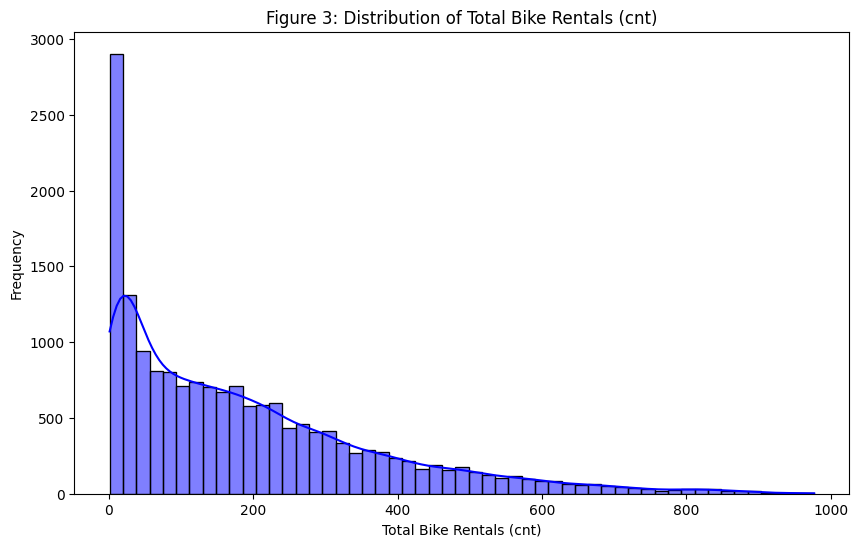

In [7835]:
# cnt Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['cnt'], kde=True, color='blue')
plt.title('Figure 3: Distribution of Total Bike Rentals (cnt)')
plt.xlabel('Total Bike Rentals (cnt)')
plt.ylabel('Frequency')
plt.show()

The distribution shows to be extremely right skewed

In [7836]:
# Basic statistics
print("Basic Statistics of 'cnt':")
print(df['cnt'].describe())

Basic Statistics of 'cnt':
count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64



Skewness: 1.28


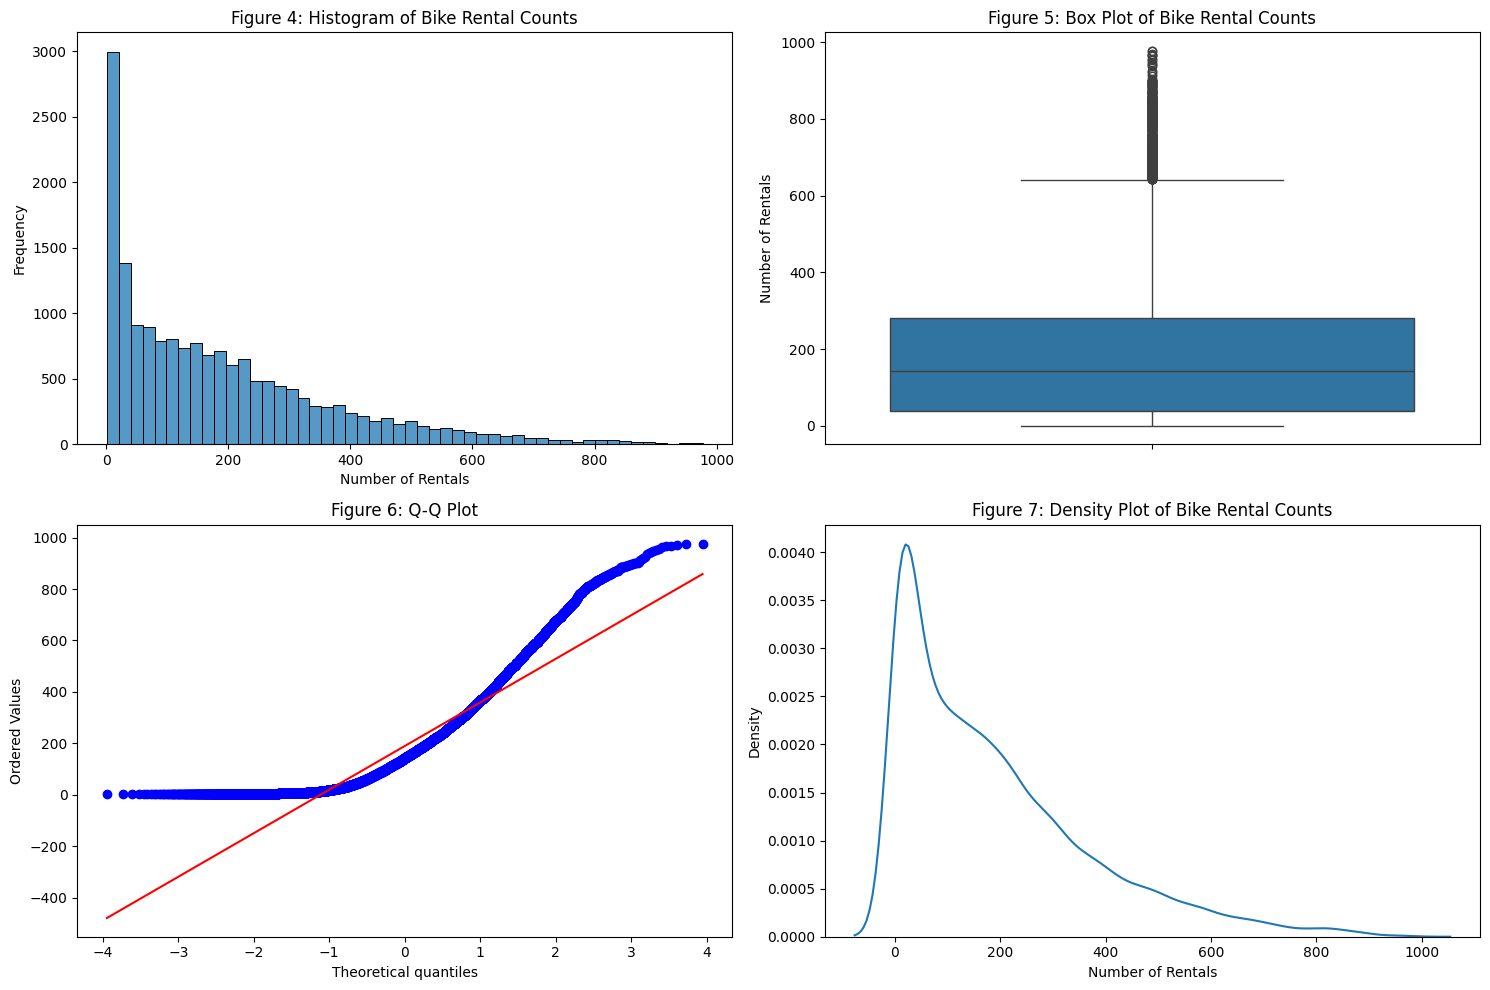


Additional Analysis:
Number of zero values: 0 (0.00%)
Number of Outliers: 505 (2.91%)
Number of Extreme Outliers: 0 (0.00%)
Range of values: 1 to 977


In [7837]:
# Calculate skewness 
skewness = df['cnt'].skew()
print(f"\nSkewness: {skewness:.2f}")

plt.figure(figsize=(15, 10))

# 1. Histogram
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='cnt', bins=50)
plt.title('Figure 4: Histogram of Bike Rental Counts')
plt.xlabel('Number of Rentals')
plt.ylabel('Frequency')

# 2. Box plot
plt.subplot(2, 2, 2)
sns.boxplot(y=df['cnt'])
plt.title('Figure 5: Box Plot of Bike Rental Counts')
plt.ylabel('Number of Rentals')

# 3. Q-Q plot
plt.subplot(2, 2, 3)
stats.probplot(df['cnt'], dist="norm", plot=plt)
plt.title('Figure 6: Q-Q Plot')

# 4. Density plot
plt.subplot(2, 2, 4)
sns.kdeplot(data=df, x='cnt')
plt.title('Figure 7: Density Plot of Bike Rental Counts')
plt.xlabel('Number of Rentals')

plt.tight_layout()
plt.show()

# Additional analysis
print("\nAdditional Analysis:")
# Count of zero values
zero_count = (df['cnt'] == 0).sum()
print(f"Number of zero values: {zero_count} ({zero_count/len(df)*100:.2f}%)")

# Count of outliers (using IQR method)
Q1 = df['cnt'].quantile(0.25)
Q3 = df['cnt'].quantile(0.75)
IQR = Q3 - Q1

# Regular Outliers (1.5 × IQR rule)
outliers = df[(df['cnt'] < (Q1 - 1.5 * IQR)) | (df['cnt'] > (Q3 + 1.5 * IQR))]

# Extreme Outliers (3.0 × IQR rule)
extreme_outliers = df[(df['cnt'] < (Q1 - 3 * IQR)) | (df['cnt'] > (Q3 + 3 * IQR))]

print(f"Number of Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
print(f"Number of Extreme Outliers: {len(extreme_outliers)} ({len(extreme_outliers)/len(df)*100:.2f}%)")

print(f"Range of values: {df['cnt'].min()} to {df['cnt'].max()}")

In [7838]:
mean_cnt = df['cnt'].mean()
std_cnt = df['cnt'].std()
cv = (std_cnt / mean_cnt) * 100

print(f"Mean: {mean_cnt}")
print(f"Standard Deviation: {std_cnt}")
print(f"Coefficient of Variation (CV): {cv:.2f}%")

Mean: 189.46308763450142
Standard Deviation: 181.38759909186473
Coefficient of Variation (CV): 95.74%


As seen on the measure of Skewness and justified by graphs, the data is highly right skewed (1.28).
The coefficient of variation indicates that the variability of the data is also very high which needs to be taken into consideration for transformations like logarithmic to stabilize variance and reduce skewness. 

Such skewness and variability can result in non-linearity between predictors and the target, making it difficult for a linear regression model to accurately capture relationships. Additionally, high variability often implies heteroscedasticity, where the variance of residuals is not constant, potentially leading to unreliable predictions. Furthermore, the presence of outliers can disproportionately influence model performance, making the model less robust. 

Transforming the target can help stabilize variance, reduce the influence of outliers, and produce more normally distributed residuals, which is essential for improving linear regression accuracy, interpretability, and reliability.


Moreover, since the cnt variable does not contain 0 counts, there will be no problems with defining this transformation (the logarithm of 0 is undefined)



In [7839]:
# Checking for invalid values
invalid_counts = len(df[df['cnt'] < 0])
print(f'Invalid Negative Counts: {invalid_counts}')

Invalid Negative Counts: 0


### 1.2 Exploring Influences 

#### Correlation Matrix

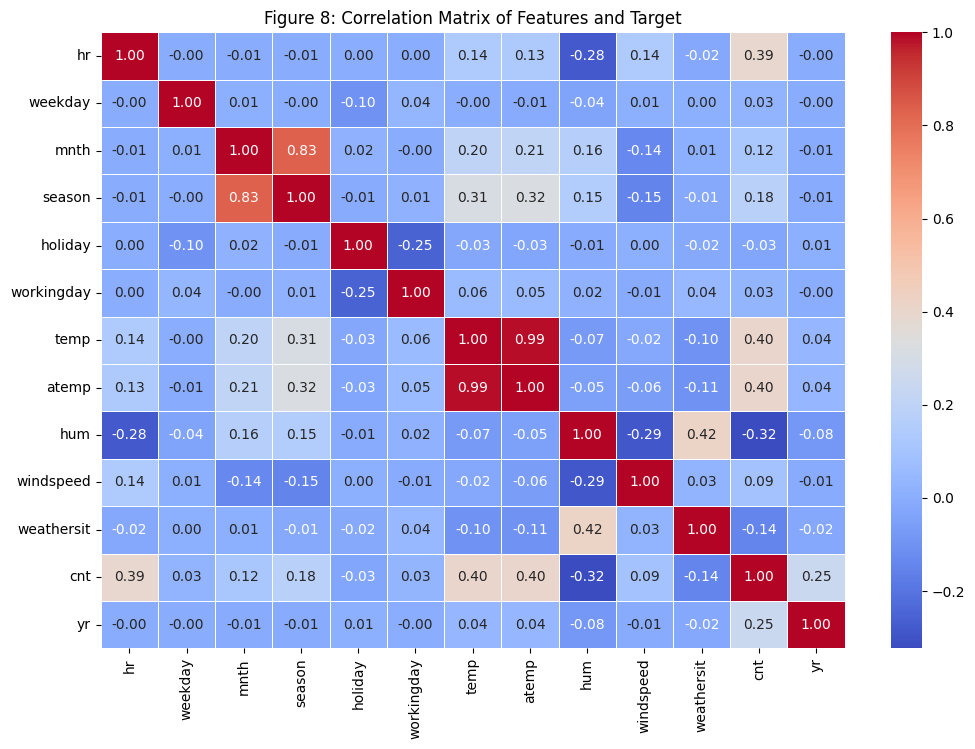

In [7840]:
# Compute the correlation matrix
corr = df[['hr', 'weekday', 'mnth', 'season', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'cnt', 'yr']].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Figure 8: Correlation Matrix of Features and Target')
plt.show()

Feature Correlation Analysis:

1. temp and atemp

have a near-perfect positive correlation (0.99). This is expected as both represent temperature in one different ways (feeling vs actual). One of them will be considered to be dropped as including both of these features in your model could cause multicollinearity issues, which may affect linear models' performance and interpretability. (atemp)

2. mnth and season

are highly correlated (0.83). This makes sense because months are divided into seasons. Season has a higher correlation with cnt than month so month will be considered to be dropped.



Correlation with Target Variable:

1. temp and atemp 

show a moderate positive correlation with cnt (0.40 each). Meaning that higher temperatures are associated with higher bike rentals, which is intuitive since people prefer biking in warmer weather.

2. hr 

shows a moderate positive correlation with cnt (0.39). This is likely due to specific hours of the day having higher rental activity (e.g., rush hours).

3. hum 

shows a moderate negative correlation with cnt (-0.32), indicating that higher humidity may discourage bike rentals.

4. windspeed 

shows a weak positive correlation (0.09) which implies it might have a small impact on the bike rentals. 

5. weathersit 

shows a negative correlation (-0.14), suggesting bad weather conditions are associated with fewer bike rentals. This is a pretty low correlation with the target variable, however an interaction term between humidity and weather situation could be worth conidering since they have a correlation of 0.44

    


6. holiday (Correlation = -0.03), workingday (Correlation = 0.03), weekday (Correlation = 0.03) have a very low correlation with the target so they could also be worth dropping.

### 1.3 Relationships 

#### Interactions

To identify meaningful interaction effects in the dataset, a systematic statistical approach was applied. First, a copy of the dataset was created, and all numerical features (excluding the target cnt) were selected. Then, all possible pairwise combinations of these numerical features were generated to form new interaction terms. These interaction terms were added as new columns to the dataset. Next, a linear regression model was fitted using statsmodels.OLS, including all original and interaction features. This model allowed to examine the statistical significance (p-values) of each interaction term. Features and interactions with p-values below 0.05 were considered statistically significant, suggesting they may carry important combined effects on the target variable.

In [7841]:
import pandas as pd
import statsmodels.api as sm
from itertools import combinations

# Step 1: Create a copy of your dataset for interaction experiments
df_interaction = df.copy()

# Step 2: Define numeric features (excluding the target)
numeric_features = df_interaction.select_dtypes(include='number').columns.tolist()
numeric_features.remove('cnt')  # Ensure target is excluded

# Step 3: Efficiently generate interaction terms using a dictionary
interaction_data = {}
for f1, f2 in combinations(numeric_features, 2):
    interaction_col = f'{f1}_x_{f2}'
    interaction_data[interaction_col] = df_interaction[f1] * df_interaction[f2]

# Step 4: Create a DataFrame with all interaction terms at once
interaction_df = pd.DataFrame(interaction_data)

# Step 5: Concatenate to the original
df_interaction = pd.concat([df_interaction, interaction_df], axis=1)

# Step 6: Prepare data for regression
X = df_interaction.drop(columns='cnt').select_dtypes(include='number')
X = sm.add_constant(X)
X = X.dropna()

y = df_interaction.loc[X.index, 'cnt']

# Step 7: Fit the linear model
model = sm.OLS(y, X).fit()

# Step 8: Show model summary and significant features
print(model.summary())

significant_features = model.pvalues[model.pvalues < 0.05].sort_values()
print("\nSignificant features (p < 0.05):")
print(significant_features)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.378e+24
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:23:50   Log-Likelihood:             3.3801e+05
No. Observations:               17379   AIC:                        -6.758e+05
Df Residuals:                   17259   BIC:                        -6.749e+05
Df Model:                         119                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -7

In [7842]:
# Significant features (p < 0.05)
significant_features = model.pvalues[model.pvalues < 0.05].sort_values()
print(significant_features)

casual                  0.0
registered              0.0
holiday_x_workingday    0.0
dtype: float64


Interactions that will be further explored:

The p-value for hr_x_workingday is extremely low: 5.97e-14, meaning this interaction is highly statistically significant in predicting bike count.
Commuting behavior is very different on weekdays vs weekends. Rush hours (like 8 or 17) are meaningful only on working days. On weekends, demand shifts to mid-day leisure rides.

On the other hand, multiple highly significant interaction terms involve temperature and humidity (such as workingday × hum, temp × atemp, and hr × hum). This means that they do not impact bike demand on their own, their effect changes depending on the context. Hence, introducing temp × hum helps capture a meaningful interaction. From an interpretability perspective, it is understood that people are more likely to ride bikes when it is warm and dry, while high humidity during hot weather may discourage usage due to discomfort. Which makes the inclusion of a temp × hum worth for further analysis. 

#### average hourly bike demand during the week, month, day

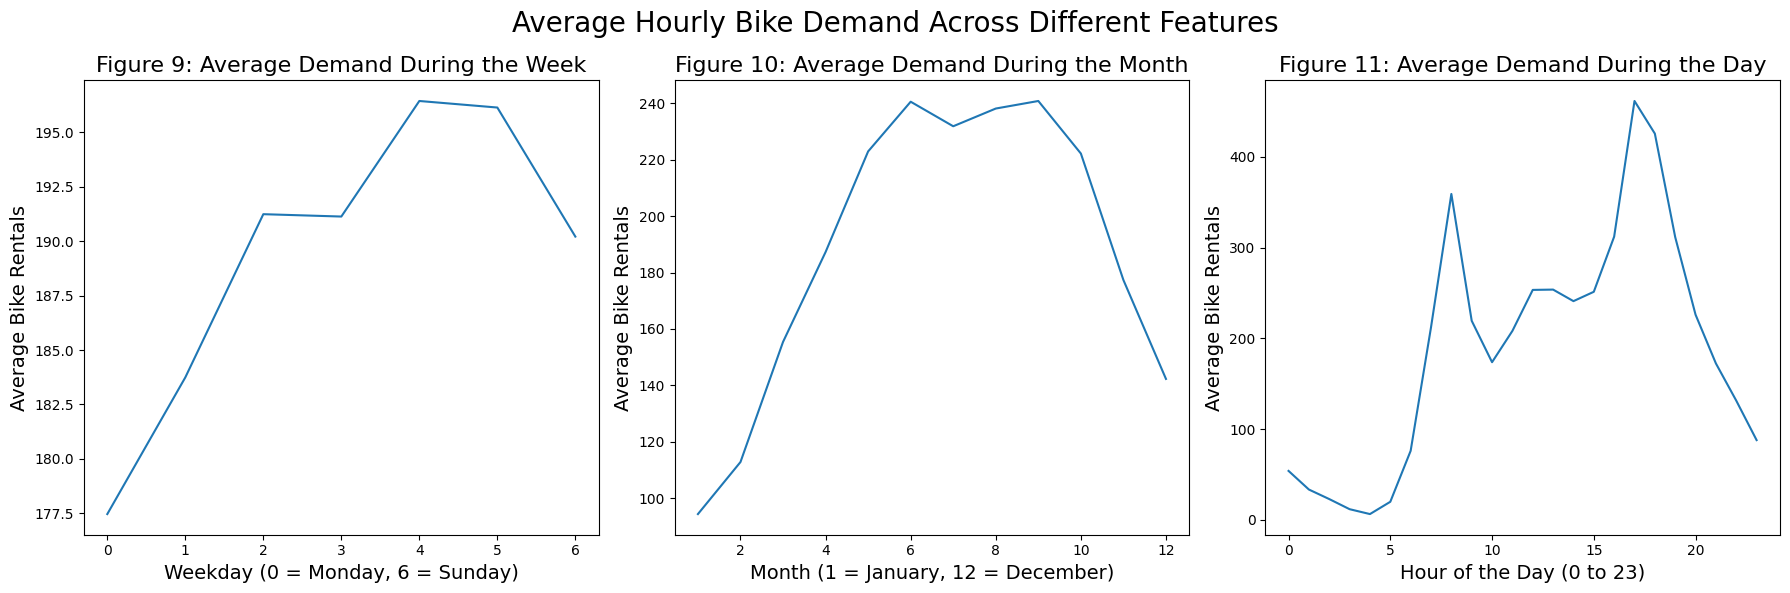

In [7843]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Average Hourly Bike Demand Across Different Features', fontsize=20)

# Plot 1: Average Demand During the Week (weekday)
sns.lineplot(ax=axes[0], x='weekday', y='cnt', data=df, estimator='mean', errorbar=None)
axes[0].set_title('Figure 9: Average Demand During the Week', fontsize=16)
axes[0].set_xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=14)
axes[0].set_ylabel('Average Bike Rentals', fontsize=14)

# Plot 2: Average Demand During the Month (mnth)
sns.lineplot(ax=axes[1], x='mnth', y='cnt', data=df, estimator='mean', errorbar=None)
axes[1].set_title('Figure 10: Average Demand During the Month', fontsize=16)
axes[1].set_xlabel('Month (1 = January, 12 = December)', fontsize=14)
axes[1].set_ylabel('Average Bike Rentals', fontsize=14)

# Plot 3: Average Demand During the Day (hr)
sns.lineplot(ax=axes[2], x='hr', y='cnt', data=df, estimator='mean', errorbar=None)
axes[2].set_title('Figure 11: Average Demand During the Day', fontsize=16)
axes[2].set_xlabel('Hour of the Day (0 to 23)', fontsize=14)
axes[2].set_ylabel('Average Bike Rentals', fontsize=14)

plt.tight_layout()
plt.show()


"Average Demand During the Day" shows clear patterns by hour, with sharp peaks for typical commuting hours. These spikes strongly suggest that people use bikes for work related travel during weekdays.

Meanwhile, "Average Demand During the Week" shows a relatively consistent demand throughout the weekdays, with only slight differences, indicating that weekday alone might not capture the entire variation. This leads to the idea that hourly demand might vary depending on whether it's a working day or weekend.

This is further explored in "hour and working day"

#### wheather situation across seasons 

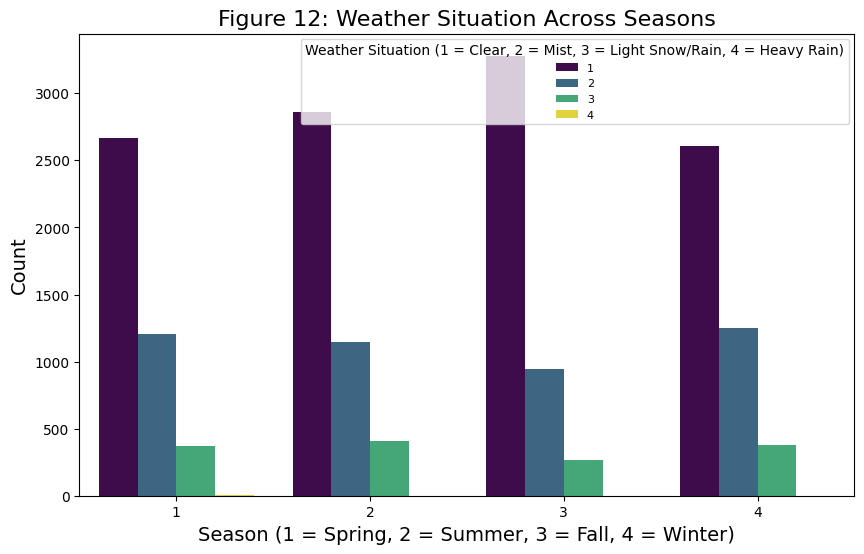

In [7844]:
plt.figure(figsize=(10, 6))
sns.countplot(x='season', hue='weathersit', data=df, palette='viridis')
plt.title('Figure 12: Weather Situation Across Seasons', fontsize=16)
plt.xlabel('Season (1 = Spring, 2 = Summer, 3 = Fall, 4 = Winter)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Weather Situation (1 = Clear, 2 = Mist, 3 = Light Snow/Rain, 4 = Heavy Rain)', fontsize= 8)
plt.show()

Weather situations across all four seasons appears quite stable. There does not appear to be a strong or distinct relationship between season and weather situation.

Note: Heavy Rain needs to be explored in "1.4 Patterns, Outliers and Anomalies"

#### temp and humidity 

/var/folders/_l/fwt_9dvs30g55rs94h95qn8w0000gn/T/ipykernel_46471/2045363877.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_copy.pivot_table(values='cnt', index='temp_range', columns='hum_range', aggfunc='mean')


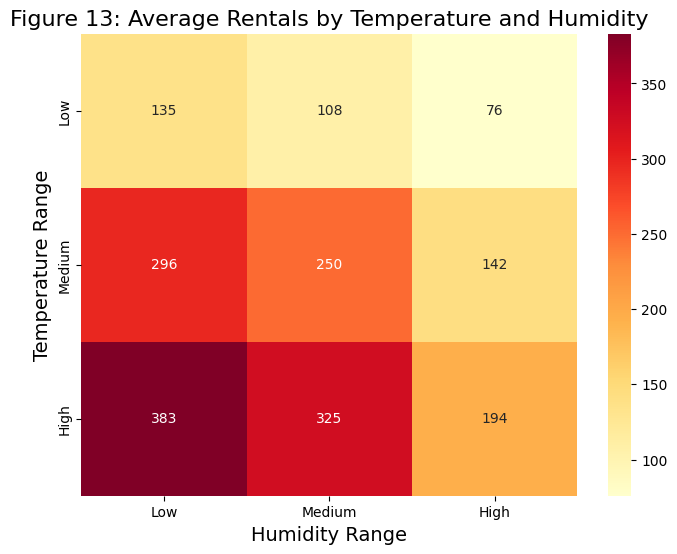

In [7845]:
df_copy = df.copy()

# Define temperature and humidity bins on the copied dataframe
df_copy['temp_range'] = pd.cut(df_copy['temp'], bins=3, labels=['Low', 'Medium', 'High'])
df_copy['hum_range'] = pd.cut(df_copy['hum'], bins=3, labels=['Low', 'Medium', 'High'])

# Calculate average rentals per bin combination
pivot_table = df_copy.pivot_table(values='cnt', index='temp_range', columns='hum_range', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title('Figure 13: Average Rentals by Temperature and Humidity', fontsize=16)
plt.xlabel('Humidity Range', fontsize=14)
plt.ylabel('Temperature Range', fontsize=14)
plt.show()

The heatmap illustrates how bike rental counts vary depending on combinations of temperature and humidity levels, revealing a potential interaction effect between these two variables. As seen in the plot, high temperatures combined with low humidity correspond to the highest average rentals, while high humidity appears to negatively impact rentals irrespective of temperature. For example, bike usage drops significantly when humidity is high even if the temperature is favorable. This pattern suggests that the influence of temperature on bike rentals is not constant but instead depends on the level of humidity. So, incorporating an interaction term between temperature and humidity allows the model to better capture this relationship and improve prediction accuracy.

#### hour and working day

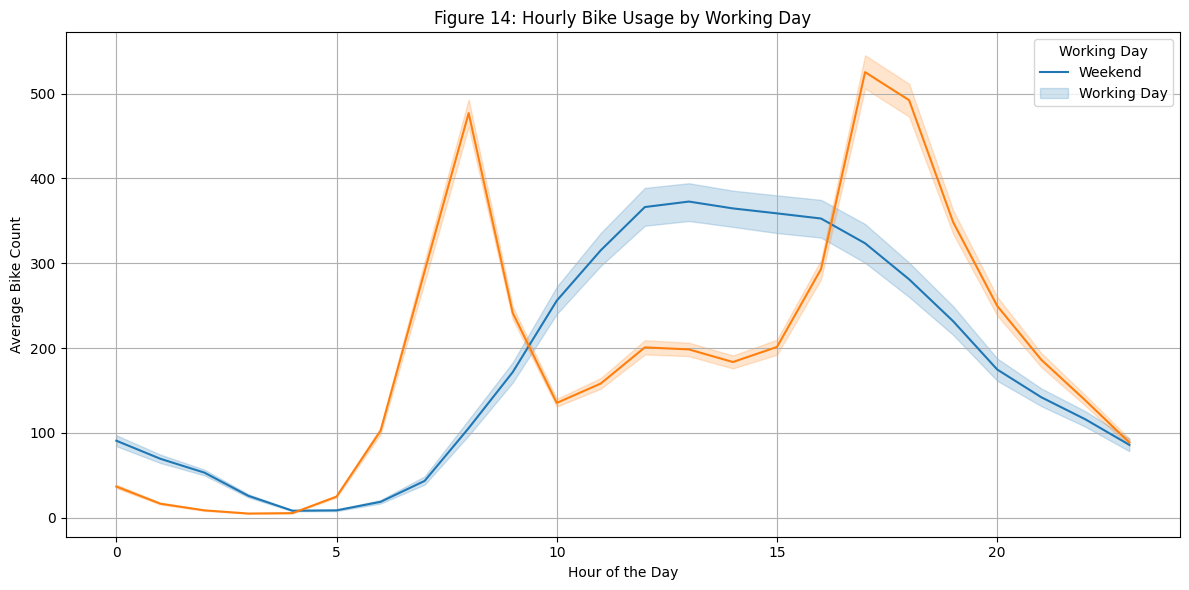

In [7846]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hr', y='cnt', hue='workingday', estimator='mean')

plt.title('Figure 14: Hourly Bike Usage by Working Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Bike Count')
plt.legend(title='Working Day', labels=['Weekend', 'Working Day'])
plt.grid(True)
plt.tight_layout()
plt.show()


The line plot reveals distinct patterns in bike usage between working days and weekends, indicating a strong interaction between the hour of the day and the workingday variable. On working days, the orange line displays two sharp peaks: one around 8 and another near 17–8, corresponding to typical commuting hours. In contrast, the blue line for weekends shows a single, broader peak occurring around midday to early afternoon, reflecting more leisurely usage. This divergence in shape implies that the effect of hour on bike rentals depends on whether the day is a working day or not.


### 1.4 Patterns, Outliers and Anomalies

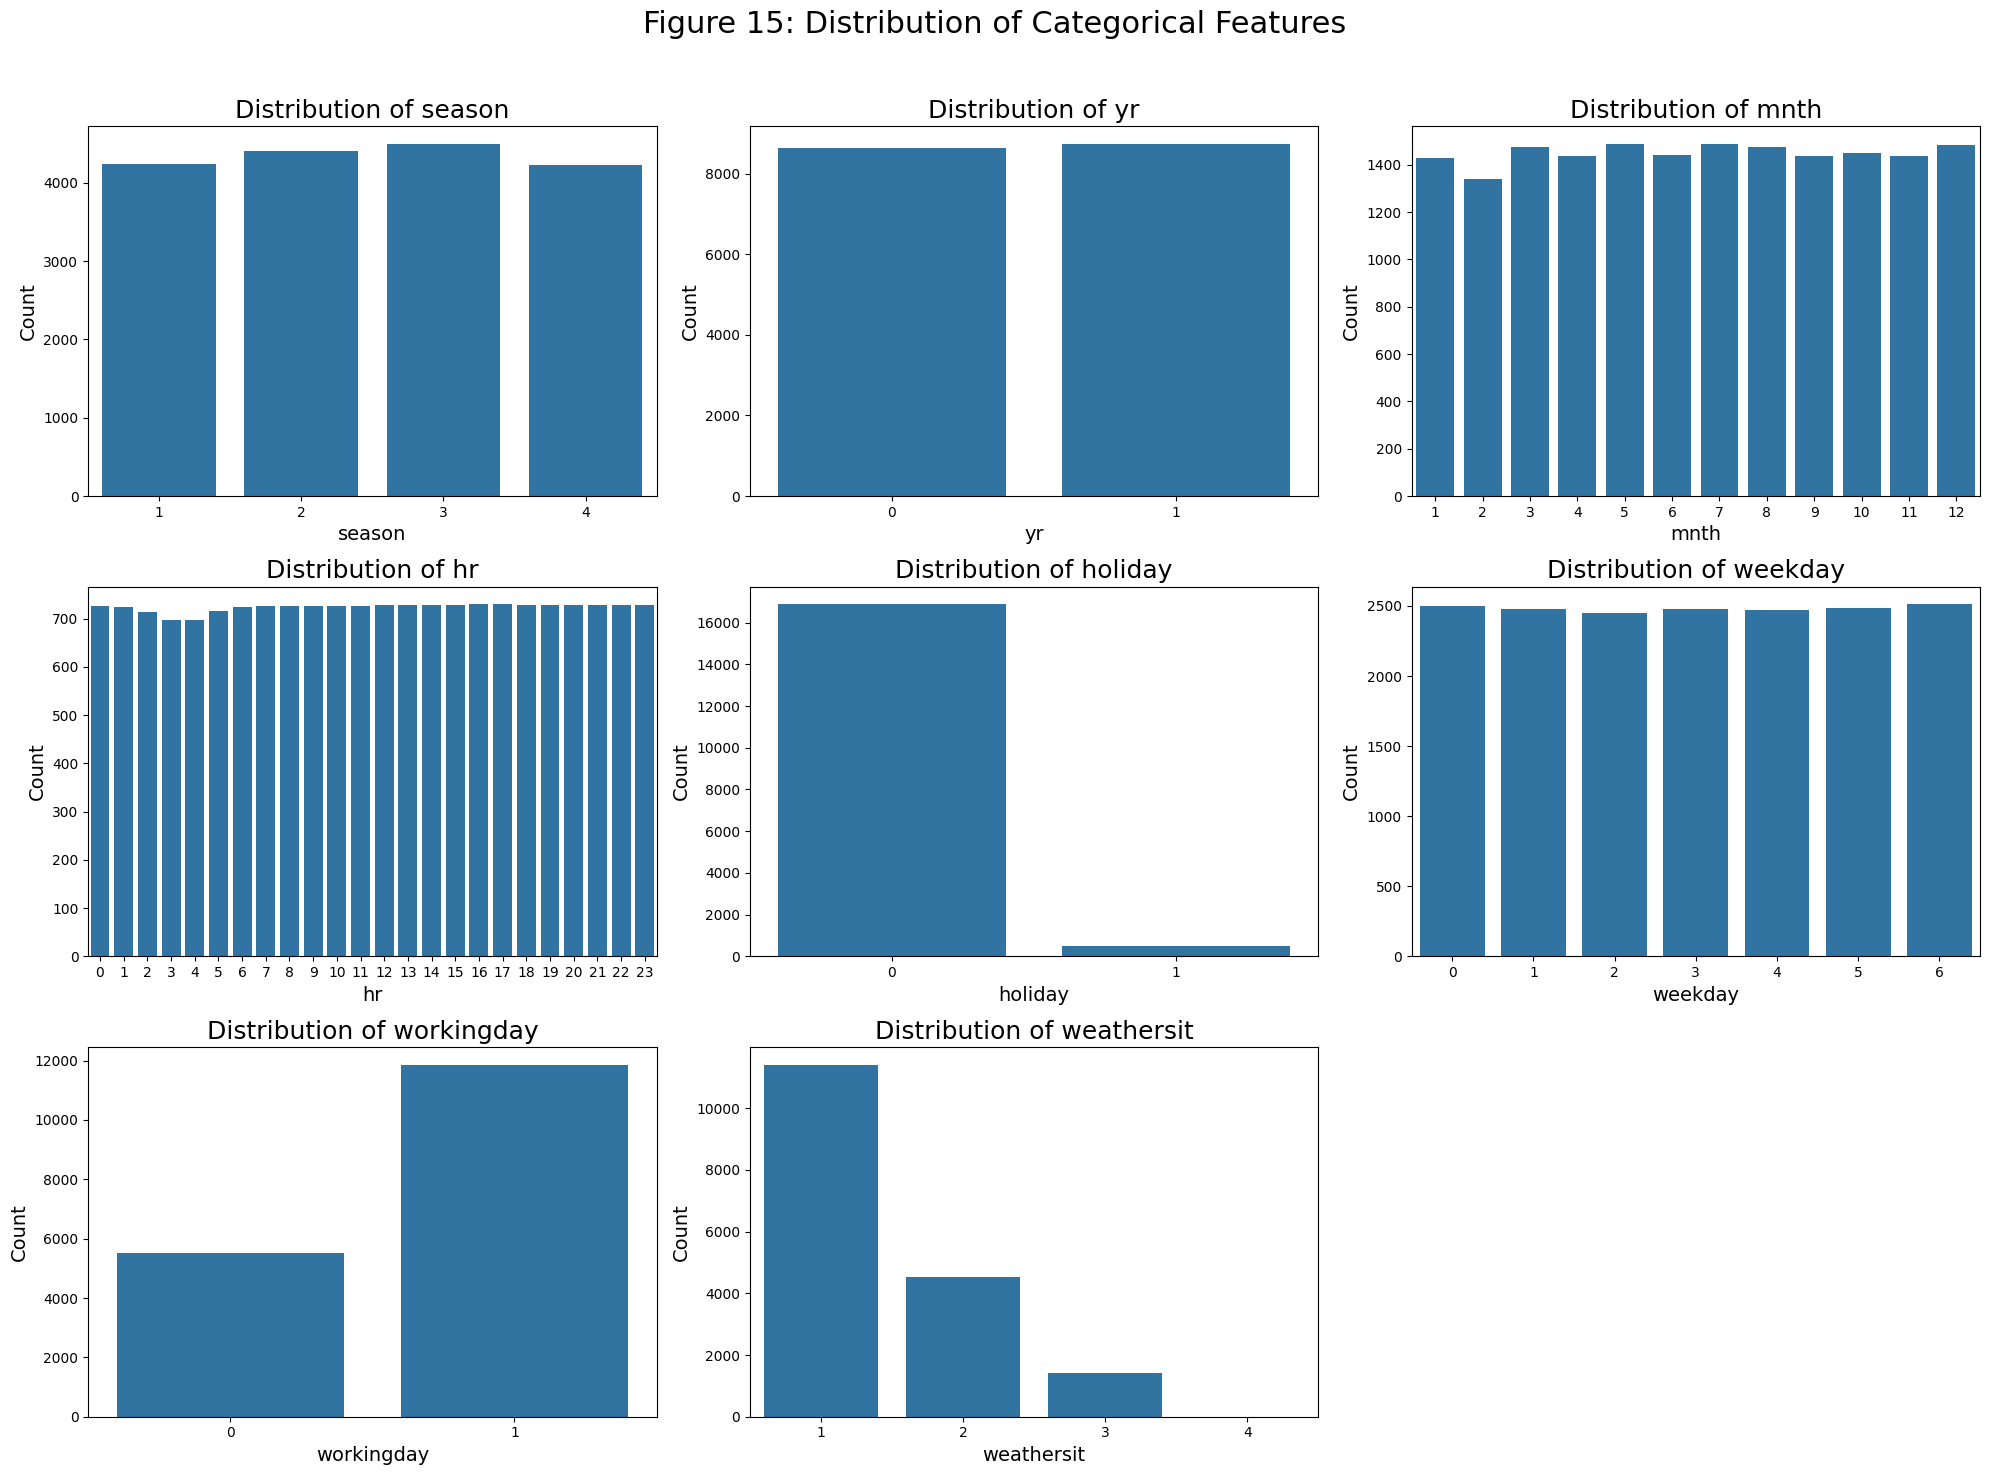

In [7847]:
#CATEGORICAL FEATURES 
# List of categorical features to plot
categorical_features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']

# Initialize the figure
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Figure 15: Distribution of Categorical Features', fontsize=22)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each categorical feature
for i, feature in enumerate(categorical_features):
    sns.countplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}', fontsize=18)
    axes[i].set_xlabel(feature, fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)

# Remove the last empty subplot (if any)
if len(categorical_features) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

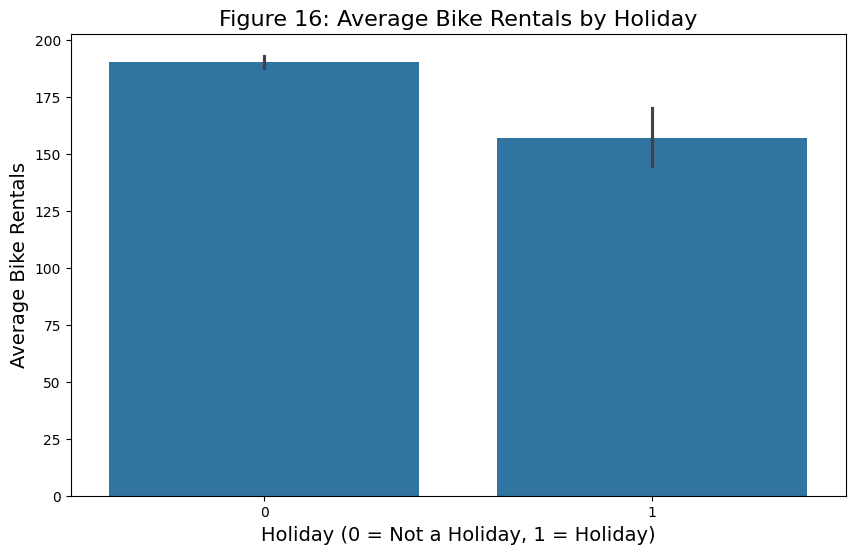

In [7848]:
plt.figure(figsize=(10, 6))
sns.barplot(x='holiday', y='cnt', data=df, estimator='mean')
plt.title('Figure 16: Average Bike Rentals by Holiday', fontsize=16)
plt.xlabel('Holiday (0 = Not a Holiday, 1 = Holiday)', fontsize=14)
plt.ylabel('Average Bike Rentals', fontsize=14)
plt.show()

Despite the fact that holidays are only about 2.88% of the data (500 entries vs. 16879 non-holidays), the average number of bike rentals on holidays is similar to that of non-holidays.
If holidays were truly unimportant, you would expect the rental numbers to drop significantly.

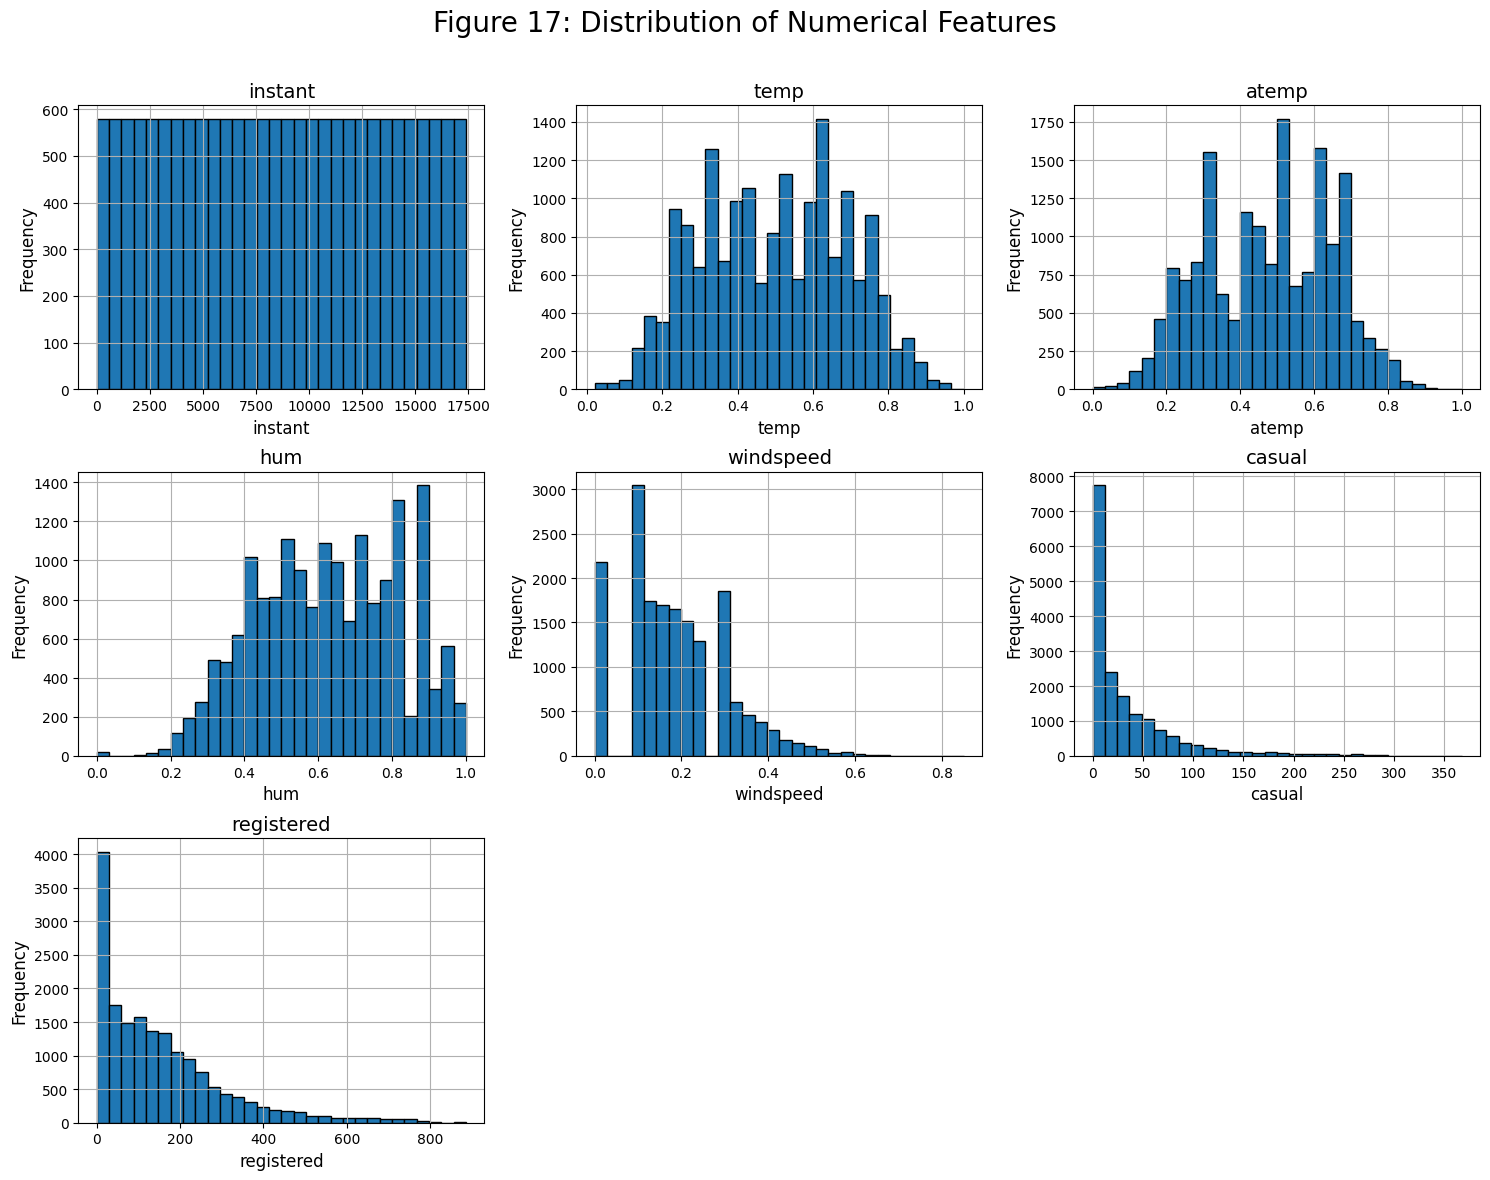

In [7849]:
#NUMERICAL FEATURES
numerical_features = ['instant', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']

# Define the number of rows and columns for the subplot grid
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
fig.suptitle('Figure 17: Distribution of Numerical Features', fontsize=20)

# Flattening axes for easier iteration
axes = axes.flatten()

# Plotting each numerical feature in a subplot
for i, feature in enumerate(numerical_features):
    axes[i].hist(df[feature], bins=30, edgecolor='black')
    axes[i].set_title(f'{feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].grid(True)

# Hide any unused subplots
for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  
plt.show()

The distribution of the windspeed is right skewed and the variable shows an unusually large spike at 0, suggesting that a significant number of windspeed readings are either missing or defaulted to zero. In real world it is wierd for winspeed to be exactly 0. This could distort the model’s understanding of how wind affects bike rentals, especially if zero doesn’t truly represent calm conditions. Dropping the variable is considered.

#### wheathersit

In [7850]:
df["weathersit"].value_counts()

weathersit
1    11413
2     4544
3     1419
4        3
Name: count, dtype: int64

Since there are only 3 "heavy_rain" events, we cannot use this category to train machine learning models with cross validation. Instead, we simplify the representation by collapsing those into the "rain" category.

In The provided Information about the wheathersit there is no explanation for the fourth category, however they appear to be ranging from best 1 to worst 4 so we will collapse 4 with 3 

In [7851]:
# Replace all occurrences of '4' in the 'weathersit' column with '3'
df['weathersit'] = df['weathersit'].replace(4, 3)

df['weathersit'].value_counts()

weathersit
1    11413
2     4544
3     1422
Name: count, dtype: int64

In [7852]:
df["season"].value_counts()

season
3    4496
2    4409
1    4242
4    4232
Name: count, dtype: int64

In [7853]:
df["holiday"].value_counts()

holiday
0    16879
1      500
Name: count, dtype: int64

#### Rentals Over time

Index is used as time

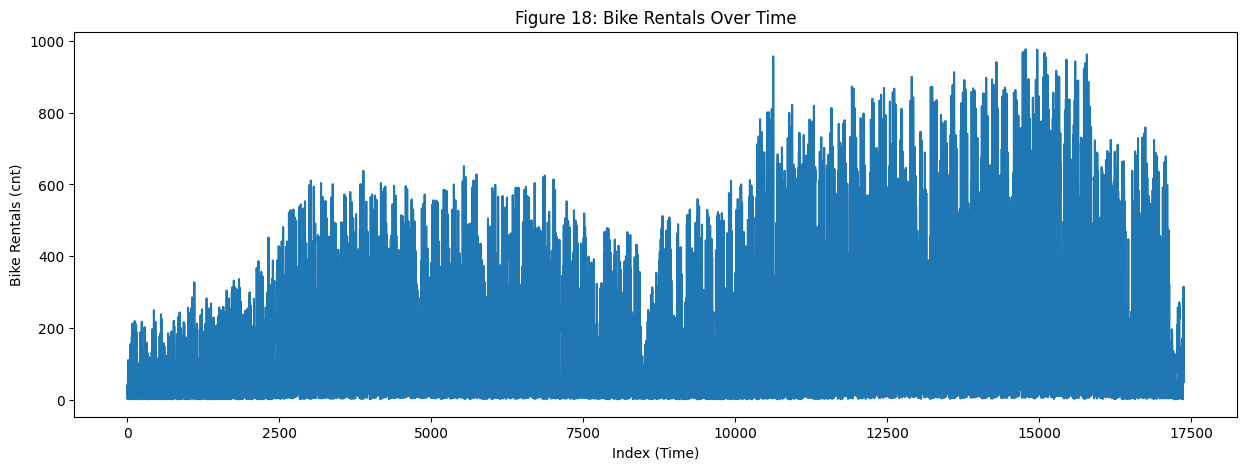

In [7854]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=df.index, y='cnt', data=df)
plt.title('Figure 18: Bike Rentals Over Time')
plt.xlabel('Index (Time)')
plt.ylabel('Bike Rentals (cnt)')
plt.show()

There’s a noticeable increase in bike usage over time, especially in the second half of the dataset. This could be due to rising popularity of the business or more bikes introduced.

There are several sharp drops or flat-line sections (especially around indices 8500 and 17300) that might indicate missing data or reduced activity due to weather impact.

There are spikes throughout probably due to rush hour peaks, weekends and weekdays.

### 1.5 Columns Drop

#### Casual and Registered

The features Casual and Registered are directly linked to our target variable "cnt" as they represent two distinct categories of users: casual users (Single Trip, 24-Hour Pass, 3-Day Pass or 5-Day Pass) and registered users (Annual Member, 30-Day Member or Day Key Member)
since they both represent the count of users either registered or casual. 
Since supposedly one bike is rented by one person
The sum of Casual + Registered = cnt

 - extracted from https://capitalbikeshare.com/system-data

EXTRACT INFO

In [7855]:
# Check if the sum of 'casual' and 'registered' equals 'cnt' for all rows
check = (df['casual'] + df['registered']) == df['cnt']

# Count the number of rows where the condition is True
true_count = check.sum()

# Count the total number of rows in the dataset
total_count = len(df)

# Display results
if true_count == total_count:
    print(f"The condition holds true for all {total_count} rows.")
else:
    print(f"The condition does NOT hold true for all rows.")
    print(f"Number of rows where the condition fails: {total_count - true_count}")


The condition holds true for all 17379 rows.


In [7856]:
df.drop(columns=["casual","registered"], inplace=True)

#### Instant and dtedat

Instant: 
Instant holds 17379 and, accordingly, is described as an ID for record index. Since this provides no meaningful information, and may in fact introduce noise it is meaningful to drop it.
The instant column is just a counter/index with no inherent meaning or relationship to the target variable (cnt).
Since instant increases sequentially, it is highly correlated with time progression in the dataset.
Using it as a feature would leak information about the order of entries without providing any real insights about the bike rentals themselves.

dteday:A model cannot directly interpret a date string (YYYY-MM-DD) without additional processing. and the dataset already has other features that capture important temporal information:
ncluding dteday along with the broken-down temporal features (yr, mnth, etc.) introduces redundancy and inconsistency in how the data is represented.

why staying with the separate instead of all together?
1. numerical instead of string
Splitting the date allows the model to independently understand how each aspect of time affects the target variable (cnt)
we can then manipulate each feature independently which may help us get a higher accuracy 

Hour is cyclic so it might be better to encode with sine and cosine transformations which is not the case for month.
We could also create interaction terms 

First extract day and then drop 

It could be relevant if there are seasonal patterns or monthly trends in your data. For example, demand might be higher on the first day of the month (payday) or towards the end of the month.

In [7857]:
# Ensure 'dteday' is in datetime format
df['dteday'] = pd.to_datetime(df['dteday'])

# Extract the day of the month and add it as a new column
df['day'] = df['dteday'].dt.day

# Display the first few rows to confirm
df[['dteday', 'day']].head()

,dteday,day
0,2011-01-01,1
1,2011-01-01,1
2,2011-01-01,1
3,2011-01-01,1
4,2011-01-01,1


In [7858]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,datetime,day
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,2011-01-01 00:00:00,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,2011-01-01 01:00:00,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,2011-01-01 02:00:00,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,2011-01-01 03:00:00,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,2011-01-01 04:00:00,1


In [7859]:
df.drop(columns=["instant","dteday"], inplace=True)

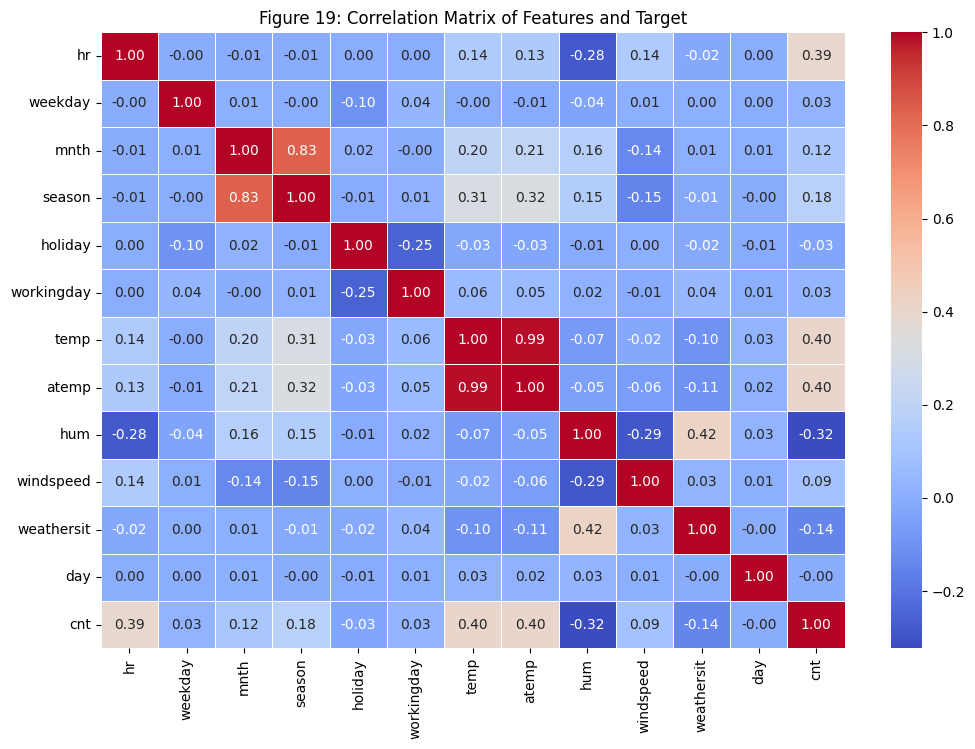

In [7860]:
# Compute the correlation matrix
corr = df[['hr', 'weekday', 'mnth', 'season', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'day', 'cnt']].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Figure 19: Correlation Matrix of Features and Target')
plt.show()

Since there is no correlation it is dropped

In [7861]:
df.drop(columns=['day'], inplace=True)

## 2. Splitting Dataset

The dataset in split chronologically into training (for model training), validation (for hyperparameter tuning in Random Forest and Gradient Boosting) and testing (for the final evaluation of the model). This means early points are used for training, the next portion for validation and the last portion for testing. This ensures the model is trained on past data and evaluated on future data, avoiding data leakage.

In [7862]:
df = df.sort_values(by=['datetime']).reset_index(drop=True)

Ensure correct sorting:

In [7863]:
df.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,datetime
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,2011-01-01 00:00:00
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,2011-01-01 01:00:00
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,2011-01-01 02:00:00
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,2011-01-01 03:00:00
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,2011-01-01 04:00:00


In [7864]:
df.iloc[183:188]

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,datetime
183,1,0,1,22,0,6,0,1,0.12,0.1061,0.36,0.3881,34,2011-01-08 22:00:00
184,1,0,1,23,0,6,0,1,0.10,0.0606,0.39,0.4478,22,2011-01-08 23:00:00
185,1,0,1,0,0,0,0,1,0.10,0.0758,0.42,0.3881,25,2011-01-09 00:00:00
186,1,0,1,1,0,0,0,1,0.10,0.0606,0.42,0.4627,12,2011-01-09 01:00:00
187,1,0,1,2,0,0,0,1,0.10,0.0606,0.46,0.4627,11,2011-01-09 02:00:00


In [7865]:
df.tail(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,datetime
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119,2012-12-31 19:00:00
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89,2012-12-31 20:00:00
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90,2012-12-31 21:00:00
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61,2012-12-31 22:00:00
17378,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,49,2012-12-31 23:00:00


Two common split strategies were considered: 60% training, 20% validation and 20% test and 80% training, 10% validation and 10% test. 

Using an 80% training split is usually preferred for this dataset size (17,378 rows) because it maximizes the information available to the model, especially when modeling temporal dependencies with lag features or cyclic patterns. Tree-based models like Random Forest and Gradient Boosting benefit from more diversity in training to improve their decision-making. While 60-20-20 provides larger validation/test sets, the trade-off is less training context, which could undermine model learning, especially in a time series. An 80-10-10 split is a strong balance between learning capacity and performance evaluation.

The start and end dates for each set are calculated in order to perform a later check that the dataset was correctly split.

In [7866]:
#Dates for each split
total_rows = len(df)

train_end_index = int(0.8 * total_rows)
valid_end_index = train_end_index + int(0.1 * total_rows)

train_start_date = df['datetime'].iloc[0]
train_end_date = df['datetime'].iloc[train_end_index - 1]

valid_start_date = df['datetime'].iloc[train_end_index]
valid_end_date = df['datetime'].iloc[valid_end_index - 1]

test_start_date = df['datetime'].iloc[valid_end_index]
test_end_date = df['datetime'].iloc[-1]

print(f"Training Set: {train_start_date} to {train_end_date}")
print(f"Validation Set: {valid_start_date} to {valid_end_date}")
print(f"Testing Set: {test_start_date} to {test_end_date}")

Training Set: 2011-01-01 00:00:00 to 2012-08-07 11:00:00
Validation Set: 2012-08-07 12:00:00 to 2012-10-18 20:00:00
Testing Set: 2012-10-18 21:00:00 to 2012-12-31 23:00:00


In [7867]:
# Dataset Splitting
train_size = int(0.8 * len(df))
valid_size = int(0.1 * len(df))
test_size = len(df) - train_size - valid_size


train_set = df.iloc[:train_size]
valid_set = df.iloc[train_size:train_size + valid_size]
test_set = df.iloc[train_size + valid_size:]


print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(valid_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 13903
Validation set size: 1737
Test set size: 1739


The first and last rows for each set are checked to confirm the split was done properly.

In [7868]:
#Correct Split Check
first_row_train = train_set['datetime'].iloc[0]
last_row_train = train_set['datetime'].iloc[-1]

first_row_valid = valid_set['datetime'].iloc[0]
last_row_valid = valid_set['datetime'].iloc[-1]

first_row_test = test_set['datetime'].iloc[0]
last_row_test = test_set['datetime'].iloc[-1]


print(f"Train Set: {first_row_train} to {last_row_train}")
print(f"Validation Set: {first_row_valid} to {last_row_valid}")
print(f"Test Set: {first_row_test} to {last_row_test}")

Train Set: 2011-01-01 00:00:00 to 2012-08-07 11:00:00
Validation Set: 2012-08-07 12:00:00 to 2012-10-18 20:00:00
Test Set: 2012-10-18 21:00:00 to 2012-12-31 23:00:00


In [7869]:
#The variable datetime is dropped, since it was initially added to sort ensure sorting on the time for splitting
train_set = train_set.drop(columns=['datetime'])
valid_set = valid_set.drop(columns=['datetime'])
test_set = test_set.drop(columns=['datetime'])

It is important to check that distribution of the target variable remains consistent across the training, validation, and test sets. This consistency ensures that the model is learning and being evaluated on data drawn from the same underlying patterns. If the target distribution shifts significantly between these sets the model may struggle to generalize, leading to poor predictions. 

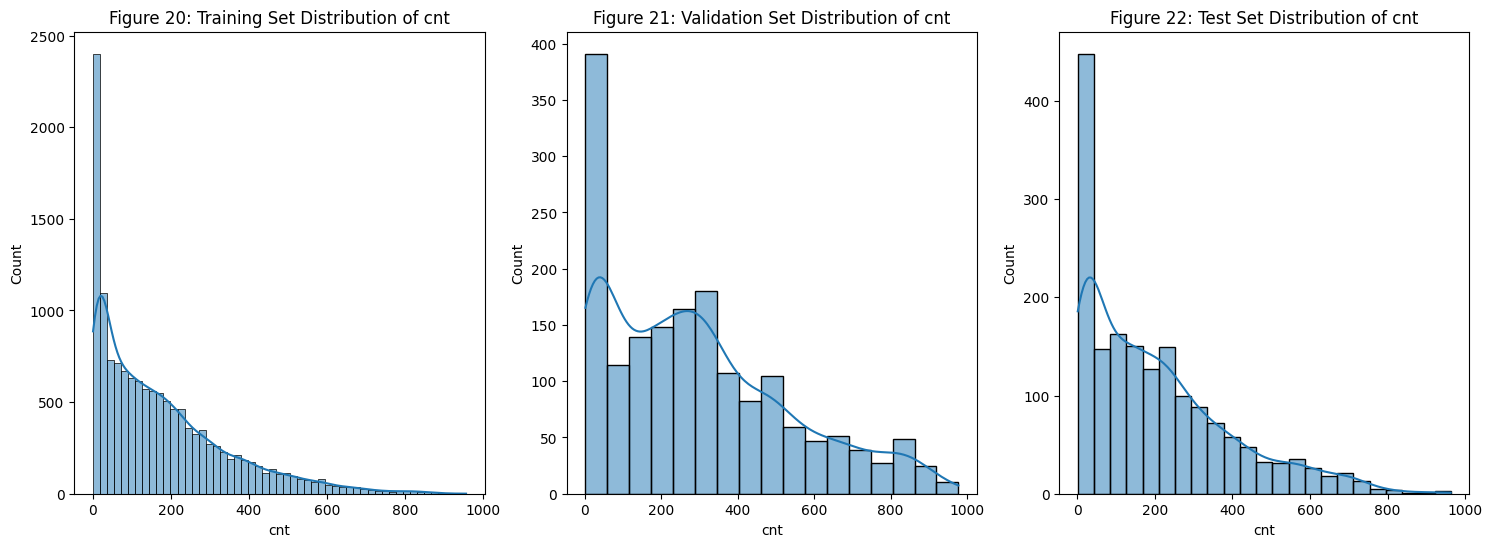

In [7870]:
# Target distribution plot for each split
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(train_set['cnt'], kde=True)
plt.title('Figure 20: Training Set Distribution of cnt')

plt.subplot(1, 3, 2)
sns.histplot(valid_set['cnt'], kde=True)
plt.title('Figure 21: Validation Set Distribution of cnt')

plt.subplot(1, 3, 3)
sns.histplot(test_set['cnt'], kde=True)
plt.title('Figure 22: Test Set Distribution of cnt')

plt.show()


The underlying distributions are not the same. However, applying techniques such as stratification, would lead to data leackage. So, in a Time Series this is expected. In order to address this issue and the extreme right skewness of the distributions the variable will be log-transformed.

#### Log Transformation 

Linear Regression benefits from this transformation since it help satisfy its assumption of homoscedasticity, which means the variance of the prediction errors should not be higher or lower depending on whether the target's value is high or low. Since transforming the target compresses the range of values it can take, and makes the distribution more symmetric, it reduces the influence of high values.

For tree ensemble models, such as Random Forest and Gradient Boosting, logarithmic transformation is usually not required. However, they may benefit from it aswell. These models split data to minimize error (typically mean squared error), and when the target has extreme values, the trees may overemphasize those points, leading to imbalanced splits. Applying a log transformation compresses the range of the target, reducing the influence of large outliers and making the distribution more symmetric. Since the data is highly right skewed, the model could benefit from this transformation by avoiding being greatly influenced by a few very large values.

Applying the log transformation after splitting the data into training, validation, and test sets is important because it prevents data leakage. Each set is transformed independently, which means the model only learns from the training data and is tested on unseen data. 

In [7871]:
# Feature and Target division
x_train = train_set.drop(columns=['cnt'])
y_train = np.log(train_set['cnt'])

x_valid = valid_set.drop(columns=['cnt'])
y_valid = np.log(valid_set['cnt'])

x_test = test_set.drop(columns=['cnt'])
y_test = np.log(test_set['cnt'])

In [7872]:
#A copy will be created to separately work on feature engineering for linear regression and tree-based models
x_train_tree = x_train.copy()
x_valid_tree = x_valid.copy()
x_test_tree = x_test.copy()

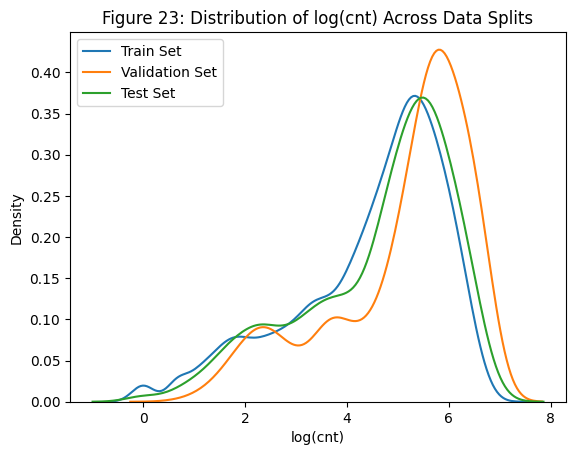

In [7873]:
# Plot distribution of 'cnt' for each split

sns.kdeplot(y_train, label='Train Set')
sns.kdeplot(y_valid, label='Validation Set')
sns.kdeplot(y_test, label='Test Set')

plt.legend()
plt.title('Figure 23: Distribution of log(cnt) Across Data Splits')
plt.xlabel('log(cnt)')
plt.ylabel('Density')
plt.show()


## 3. Feature Engineering

### Linear Regression

#### 3.1 Lag Features 

A lag feature will be used to help the model learn from past bike rental patterns. For example, the number of rentals at the same hour yesterday or last week can give useful hints about what to expect now. This captures trends and makes the predictions more accurate.

A 1-hour lag seems ideal for hourly predictions because it gives the model immediate context. And, what happened in the previous hour either directly affects what happens next or can be reflected on what will happen next. In bike rentals, patterns like rush hours or weather effects can carry over from one hour to the next, so using the last hour’s count helps the model make more accurate hourly predictions.

In order to make sure a 1-hour lag is a suitable option I will see the correlation of a 1-hour lag, 1-day lag and 7-day lag with my target variable.

In [7874]:
# Correlation check
df_copy['cnt_lag_1'] = df['cnt'].shift(1)
df_copy['cnt_lag_24'] = df['cnt'].shift(24)
df_copy['cnt_lag_168'] = df['cnt'].shift(168)

print("Correlation with lag 1:", df_copy['cnt'].corr(df_copy['cnt_lag_1']))
print("Correlation with lag 24:", df_copy['cnt'].corr(df_copy['cnt_lag_24']))
print("Correlation with lag 168:", df_copy['cnt'].corr(df_copy['cnt_lag_168']))

Correlation with lag 1: 0.8438107986135388
Correlation with lag 24: 0.8157653661278814
Correlation with lag 168: 0.8211070666590071


Once again, a 1-hour lag seems to be the best option. However, this next section will inspect the impact of the addition of this feature on data leackage.

Initially, a lag of 1 hour was introduced to the model, which resulted in a surprisingly high R^2 score for the Linear Regression.
The results can be seen bellow: 

Validation Mean Squared Error (MSE): 0.2282

Validation Mean Absolute Error (MAE): 0.3438

Validation R² Score: 0.8831

Since the dataset includes hourly data, this seemed like a valid feature to capture short-term temporal dependencies. However, after closer inspection, I realized that this assumption might not be valid. The dataset used for prediction (the UCI Bike Sharing Dataset) is derived from raw trip-level data, which includes both a start time and an end time for each trip. Unfortunately, the UCI dataset’s documentation (README) does not clarify how the target variable cnt was actually computed.

Specifically, it's unclear whether the count corresponds to the number of trips starting in a given hour, ending in that hour, or perhaps using a more complex rule (like based on the hour when the ride was mostly active). This uncertainty introduces the risk of data leakage. For example, if the original count is based on end times, and we introduce a lag of 1 hour, we might inadvertently be feeding the model information from the future. In that case, the lag feature could contain partial information about the target value itself.

The first approach is trying to discover how the count variable is processed.

The following code will take a date (randomly chosen by me) and will ensure it is not in the missing_dates csv file in order to proceed with proper calculations.
Once ensuring it is present, trips that began in between 01:00:00 y 01:59:59 (of that same date) or ended in between 01:00:00 y 01:59:59 are counted based on the original raw dataset. The calculation is based on the Start date and End date columns.
This count is compared to the count used for that same hour in the UCI Bike Share Dataset. 
If any of them match, then we could conclude that the method used for calculating the count is the speculated one. 


In [7875]:
df.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,datetime
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,2011-01-01 00:00:00
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,2011-01-01 01:00:00
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,2011-01-01 02:00:00
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,2011-01-01 03:00:00
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,2011-01-01 04:00:00


Since missing_dates.csv contain exact hour timestamps, only 2011-01-01 01:00:00 needs to be checked in missing_dates.

In [7876]:
#1 Confirm, randomly selected date is not in missing_dates
target_hour = pd.Timestamp("2011-01-01 01:00:00")

if target_hour in missing_df['datetime'].values:
    print("The date is in missing_dates.csv")
else:
    print("The date is not in missing_dates.csv")


The date is not in missing_dates.csv


In [7877]:
# Number of trips that started between 01:00:00 y 01:59:59
trips2011_df = pd.read_csv("2011-capitalbikeshare-tripdata.csv", parse_dates=["Start date", "End date"])


start_range = pd.Timestamp("2011-01-01 01:00:00")
end_range = pd.Timestamp("2011-01-01 01:59:59")


started_trips = trips2011_df[(trips2011_df["Start date"] >= start_range) & (trips2011_df["Start date"] <= end_range)]

print(f"Trips that started 1:00:00 and 1:59:59: {len(started_trips)}")


Trips that started 1:00:00 and 1:59:59: 38


In [7878]:
#Number of trips that ended between 01:00:00 y 01:59:59 
ended_trips = trips2011_df[(trips2011_df["End date"] >= start_range) & (trips2011_df["End date"] <= end_range)]

print(f"Trips that ended between 1:00:00 and 1:59:59: {len(ended_trips)}")

Trips that ended between 1:00:00 and 1:59:59: 36


In [7879]:
#cnt variable in UCI Dataset
target_hour = pd.Timestamp("2011-01-01 01:00:00")
row = df[df['datetime'] == target_hour]


print(f"Registered 'cnt' from UCI Bike Share Dataset: {row['cnt'].values[0]}")


Registered 'cnt' from UCI Bike Share Dataset: 40


It is concluded that the speculated methos were not used to find the 'cnt' variable since the counts found from the raw data differ from the counts registered in the dataset used for prediction. 

Since we cannot be certain about how the cnt variable was calculated. To avoid data leackage, a lag longer than the maximum trip duration needs to be used. 
Because if some trips lasted 12 hours, then using lag_1 might leak information from the same rental that’s already included in hour t, leading to leakage.

To do so, the maximum value in the 'duration' column in the raw datasets from 2011 and 2012 is found. This ensures that the trips in the lag feature have fully finished before the hour trying to be predicted. 

In [7880]:
folder_path = '2012-capitalbikeshare-tripdata'
raw_data_2011 = pd.read_csv('2011-capitalbikeshare-tripdata.csv')
all_files = [
    '2012Q1-capitalbikeshare-tripdata.csv', 
    '2012Q2-capitalbikeshare-tripdata.csv', 
    '2012Q3-capitalbikeshare-tripdata.csv', 
    '2012Q4-capitalbikeshare-tripdata.csv'
]

# Combined
data_frames_2012 = [pd.read_csv(os.path.join(folder_path, file)) for file in all_files]
raw_data = pd.concat([raw_data_2011] + data_frames_2012, ignore_index=True)

# Duration from seconds to hours
raw_data['duration_hours'] = raw_data['Duration'] / 3600

print("\n--- Results ---")
print("\nMax duration (in hours):", raw_data['duration_hours'].max())
max_duration_row = raw_data.loc[raw_data['duration_hours'].idxmax()]
start_of_max_duration = max_duration_row['Start date']
print("Start date of the ride with maximum duration:", start_of_max_duration)




--- Results ---

Max duration (in hours): 23.9875
Start date of the ride with maximum duration: 2011-06-09 19:18:26


Since the maximum duration has been of almost 24 hours, a 1-hour lag feature is definetely discarded.
According to the correlations found before, a 7-day lag feature seems to be the next suitable option. However, since lag features are created by shifting the target variable backward in time, the  number of missing values equal the size of the lag. This is why a 24-hour lag will be implemented despite having a slowly lower correlation with the target variable, because the missing values are significantly less.

In [7881]:
x_train['cnt_lag_24'] = y_train.shift(periods=24)
x_valid['cnt_lag_24'] = y_valid.shift(periods=24)
x_test['cnt_lag_24'] = y_test.shift(periods=24)

Handling missing values:

In [7882]:
# Filling missing values with 0
x_train['cnt_lag_24'] = x_train['cnt_lag_24'].fillna(0)
x_valid['cnt_lag_24'] = x_valid['cnt_lag_24'].fillna(0)
x_test['cnt_lag_24'] = x_test['cnt_lag_24'].fillna(0)

In [7883]:
# Check for correct filling
print("NaNs in x_train:", x_train.isna().sum().sum())
print("NaNs in x_valid:", x_valid.isna().sum().sum())
print("NaNs in x_test:", x_test.isna().sum().sum())

NaNs in x_train: 0
NaNs in x_valid: 0
NaNs in x_test: 0


Missing values in the lag feature are filled with 0 because it’s the safest option that avoids leakage. The missing values happen at the start of the dataset, where there is no previous data to pull from.
If forward fill, backward fill, or interpolation, were to be used, the values would be using information from before(null) or after, leading to leaking future data into the past.

#### 3.2 Rolling Window Statistics

This section evaluates the addition of a rolling mean feature and a rolling standard deviation feature.
This could be greately beneficial since it dynamically summarizes recent trends in the target variable.
The rolling mean gets the recent average demand and the rolling standard deviation quantifies recent variability.
Once again, a lag of 24 hours is implemented to prevent data leakage and missing values are filled with 0.

Rolling averages should be computed after splitting the data into training, validation, and test sets to avoid data leakage. Because, for example, a rolling mean for a validation point could be calculated using previous values that belong to the training set, leading to an invalid performance.

In [7884]:
x_train['cnt_rolling_mean'] = y_train.shift(24).rolling(window=3).mean().fillna(0)
x_train['cnt_rolling_std'] = y_train.shift(24).rolling(window=3).std().fillna(0)


x_valid['cnt_rolling_mean'] = y_valid.shift(24).rolling(window=3).mean().fillna(0)
x_valid['cnt_rolling_std'] = y_valid.shift(24).rolling(window=3).std().fillna(0)

x_test['cnt_rolling_mean'] = y_test.shift(24).rolling(window=3).mean().fillna(0)
x_test['cnt_rolling_std'] = y_test.shift(24).rolling(window=3).std().fillna(0)

Before proceeding, since three new features were created (cnt_lag_24, cnt_rolling_mean, cnt_rolling_std), their correlation with the target will be checked in order to decide whether to keep or eliminate them.

In [7885]:
copy = x_train.copy()
copy['cnt'] = y_train

print(copy[['cnt', 'cnt_rolling_mean', 'cnt_rolling_std', 'cnt_lag_24']].corr())

                       cnt  cnt_rolling_mean  cnt_rolling_std  cnt_lag_24
cnt               1.000000          0.782281        -0.319768    0.844336
cnt_rolling_mean  0.782281          1.000000        -0.541179    0.913029
cnt_rolling_std  -0.319768         -0.541179         1.000000   -0.374580
cnt_lag_24        0.844336          0.913029        -0.374580    1.000000


Since cnt_lag_24 and cnt_rolling_mean have a correlation of 0.85, they hold very similar information about the target, leading to multicolinearity issues. Since cnt_lag_24 has a higher correlation with the target, cnt_rolling_mean will be discarded.


In [7886]:
# Drop cnt_rolling_mean from all sets
x_train = x_train.drop(columns=['cnt_rolling_mean'])
x_valid = x_valid.drop(columns=['cnt_rolling_mean'])
x_test = x_test.drop(columns=['cnt_rolling_mean'])

#### 3.3 Extra Features Addition

is_rush_hr

As seen in "Figure 11: Average Demand During the Day" there are two clear peeks in bike usage around 8 and 17, which leads to the creation of is_rush_hour. 
These peaks are assumed to have occurred due to typical commuting hours, as people go and come out from work and school. A 1 is set if the hour is between 7 to 9 or 16 to 19, corresponding to morning and evening rush hours.

is_night

"Figure 2: Distribution of Bike Rentals (cnt) by Hour of the Day" shows significantly lower rental counts between 0 and 5, indicating a low demand during these hours. 
is_night is a binary feature that indicates whether a bike rental occurred during nighttime hours, specifically between the mentioned hours. A 1 is set if the event took place in between 0 and 5 (inclusive), and a 0 is set otherwise.
This feature helps capture patterns that are unique to nighttime activity associated with significantly reduced demand.


In [7887]:
x_train['is_rush_hour'] = x_train['hr'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)
x_valid['is_rush_hour'] = x_valid['hr'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)
x_test['is_rush_hour'] = x_test['hr'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)

x_train['is_night'] = x_train['hr'].isin([0, 1, 2, 3, 4, 5]).astype(int)
x_valid['is_night'] = x_valid['hr'].isin([0, 1, 2, 3, 4, 5]).astype(int)
x_test['is_night'] = x_test['hr'].isin([0, 1, 2, 3, 4, 5]).astype(int)


In [7888]:
df.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,datetime
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,2011-01-01 00:00:00
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,2011-01-01 01:00:00
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,2011-01-01 02:00:00
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,2011-01-01 03:00:00
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,2011-01-01 04:00:00


#### 3.4 Sine/Cosine Transformation - Cyclical Features

Cyclic encoding with sine and cosine is used to represent features that have a periodic structure. For example, hour of the day goes from 0 to 23 and starts again, meaning hour 23 is as close to 0 as it is to 22. Similarly, the week runs from 0 (Sunday) to 6 (Saturday) and then then repeat. 

Using one-hot encoding for cyclical variables would mislead the model into thinking hour 23 and 0 are very different, or that day 0 and 6 are the furthest away, when they are actually next to each other.

If one-hot encoding is used the model may incorrectly assume a linear relationship — treating hour 23 and 0, or day 6 and 0, as far apart. This misrepresentation can distort the model's understanding of time based patterns and lead to incorrect predictions.

By encoding these features using sine and cosine transformations, circular structure is preserved, allowing the model to learn relationships more accurately.




In [7889]:
def encode_cyclic_features(df):
    # Hour encoding (24-hour cycle)
    df['hr_sin'] = np.sin(2 * np.pi * df['hr']/24)
    df['hr_cos'] = np.cos(2 * np.pi * df['hr']/24)
    
    # Weekday encoding (7-day cycle)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/7)
    df = df.drop(columns=['hr', 'weekday'])
    return df

x_train = encode_cyclic_features(x_train)
x_valid = encode_cyclic_features(x_valid)
x_test = encode_cyclic_features(x_test)

#### 3.5 One-Hot Encoding - Categorical Variables

Adjacent seasons like winter (1) and fall (2) show sharper transitions rather than gradual changes in bike usage patterns due to eather events, holidays, and seasonal activities that don't follow a continuous curve. This is why one-hot seems to be more suitable rather than cyclical encoding.

While the monthly pattern in bike usage shows a general trend, it may be blurred by the fact that each month contains a mixture of different weekdays, holidays, and varying weather conditions. These fluctuations within each month can weaken the strength of any cyclical pattern. 

In [7890]:
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,datetime
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,2011-01-01 00:00:00
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,2011-01-01 01:00:00
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,2011-01-01 02:00:00
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,2011-01-01 03:00:00
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,2011-01-01 04:00:00


The fit() step is only applied to the training set to prevent data leakage. 
By fitting the encoder exclusively on the training data, the model only learns categories present during training and not from the validation or test sets. This ensures that the model generalizes properly.

In [7891]:
one_hot_cols = ["season", "mnth"]

if x_train is not None and all(col in x_train.columns for col in one_hot_cols):

    ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)  

    # Fit the encoder on the training data only (to avoid data leakage)
    ohe.fit(x_train[one_hot_cols])
    
    train_ohe = ohe.transform(x_train[one_hot_cols])
    valid_ohe = ohe.transform(x_valid[one_hot_cols])
    test_ohe = ohe.transform(x_test[one_hot_cols])


    ohe_cols = ohe.get_feature_names_out(one_hot_cols)

    # Convert the one-hot encoded arrays to DataFrames
    train_ohe_df = pd.DataFrame(train_ohe, columns=ohe_cols, index=x_train.index)
    valid_ohe_df = pd.DataFrame(valid_ohe, columns=ohe_cols, index=x_valid.index)
    test_ohe_df = pd.DataFrame(test_ohe, columns=ohe_cols, index=x_test.index)

    # Drop the original categorical columns from the feature sets and join the new one-hot DataFrames
    x_train = x_train.drop(columns=one_hot_cols).join(train_ohe_df)
    x_valid = x_valid.drop(columns=one_hot_cols).join(valid_ohe_df)
    x_test = x_test.drop(columns=one_hot_cols).join(test_ohe_df)
    
    print("One-hot encoding completed successfully.")

else:
    raise ValueError("x_train is None or does not contain all required columns.")


One-hot encoding completed successfully.


#### 3.6 Ordinal Encoding - Categorical Variables

The weather conditions listed can be ordered by severity or adverse effect on bike rentals.

Based on the variables description, this is an ordering from best weather to worst weather:

1: Clear, Few clouds, Partly cloudy	1 (Best conditions for biking)

2: Mist + Cloudy	2 ()

3: Light Snow/Rain	3 (Worst conditions for biking)

Given this ordinal nature, weathersit will be treated as already ordinally encoded, and no further transformation is necessary.

#### 3.7 Scaling - Numerical Features

This step is critical to ensure all numerical features contribute equally towards the model's performance and that none affect it disproportionately their because of their greater range or magnitude.

Currently, 'temp', 'atemp', 'hum', 'windspeed', 'cnt_rolling_std' and 'cnt_lag_24' should be processed.

Standardization is perform after data splitting in order to avoid data leakage. If scaled before, the model would gain knowledge about the distribution of the test and validation data.

Two different approaches are considered: Standardization and Normalization. 

As discussed in AssignmentI:

Standardization brings the features to a common scale with mean 0 and standard deviation 1. This is done by subtracting the mean of each feature from the data points and dividing by the standard deviation. This can be applied using StandaredScaler. 

Normalization transforms the features into a specific range such as [0,1]. This is done by subtracting the minimum value of the feature and dividing by the range (maximum - minimum). This can be applied using MinmaxScaler.

While standardization usually works better with normally distributed data, normalization usually works better with uniformly distributed data. 

Standardization is used to ensure that features have the same scale, especially when they have different magnitudes.
Normalization is typically used when the data needs to be in a specific range. It generally performs well on algorithms that use distances, such as K-Nearest Neighbors (KNN). 

One of the biggest impacts to consider regarding these methods is their impact on the data distribution:
Standardization does not change the distribution of the data. Standardization only changes the spread and center of the data. Normalization, on the other hand, forces the data into a fixed range. This could compress large values or extreme outliers into a small range, leading to potential information loss and affecting model performance.

This also makes Standardization less sensitive to outliers than normalization, which may cause the latter to hide underlying patterns in the data.

Standardization is preferred over normalization for this dataset because it ensures that all features are on the same scale with a mean of 0 and a standard deviation of 1, which is crucial for Linear Regression, a linear model sensitive to feature scales. Standardization improves the model’s convergence during gradient descent optimization by allowing each feature to contribute equally, preventing larger scale features from disproportionately influencing the model. Additionally, standardization is less sensitive to outliers compared to normalization, which can distort the data when outliers are present. Since standardization uses the mean and standard deviation, it retains the spread and variance of the data, ensuring that outliers, remain identifiable without compressing the data into a narrow range. 

In [7892]:
x_train.head()

,yr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt_lag_24,cnt_rolling_std,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,0,0,0,1,0.24,0.2879,0.81,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0.22,0.2727,0.80,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,1,0.22,0.2727,0.80,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,1,0.24,0.2879,0.75,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,1,0.24,0.2879,0.75,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7893]:
# List of numerical features to scale
num_features = ['temp', 'atemp', 'hum', 'windspeed', 'cnt_rolling_std', 'cnt_lag_24']

scaler = StandardScaler()

# Fit the scaler on training data only
x_train[num_features] = scaler.fit_transform(x_train[num_features])

# Apply the same scaler (already fitted) to validation and test data
# Apply the same scaling to the validation and test data (using transform, NOT fit_transform)
x_valid[num_features] = scaler.transform(x_valid[num_features])
x_test[num_features] = scaler.transform(x_test[num_features])

# Check the result
print(x_train.head(5))


   yr  holiday  workingday  weathersit      temp     atemp       hum  \
0   0        0           0           1 -1.310866 -1.076496  0.943574   
1   0        0           0           1 -1.412024 -1.162563  0.893116   
2   0        0           0           1 -1.412024 -1.162563  0.893116   
3   0        0           0           1 -1.310866 -1.076496  0.640830   
4   0        0           0           1 -1.310866 -1.076496  0.640830   

   windspeed  cnt_lag_24  cnt_rolling_std  ...  mnth_3  mnth_4  mnth_5  \
0   -1.57778   -2.976883        -1.279033  ...     0.0     0.0     0.0   
1   -1.57778   -2.976883        -1.279033  ...     0.0     0.0     0.0   
2   -1.57778   -2.976883        -1.279033  ...     0.0     0.0     0.0   
3   -1.57778   -2.976883        -1.279033  ...     0.0     0.0     0.0   
4   -1.57778   -2.976883        -1.279033  ...     0.0     0.0     0.0   

   mnth_6  mnth_7  mnth_8  mnth_9  mnth_10  mnth_11  mnth_12  
0     0.0     0.0     0.0     0.0      0.0      0.0      0.

#### 3.8 Interaction Terms

As justified by Section "1.3 Relationship Visualization" two interaction terms are added: 

1. temperature and humidity 
A hot day might be great for biking if the air is dry, but if it is also very humid, it can feel uncomfortable and discourage riding. By creating an interaction between these two, the model can learn to recognize situations where one condition makes the other feel better or worse, which is something it can not pick up on if the features are used separately.


2. working day and hour 

People use bikes very differently depending on the day. On working days, usage spikes around the morning and evening commute, while on weekends, it is more spread out during the day. This means the impact of the hour of the day is not the same on a weekday versus a weekend, they interact. By combining hour and working day into one feature, the model can understand these changing patterns more clearly.

In [7894]:
x_train['temp_hum_interaction'] = x_train['temp'] * x_train['hum']
x_valid['temp_hum_interaction'] = x_valid['temp'] * x_valid['hum']
x_test['temp_hum_interaction'] = x_test['temp'] * x_test['hum']


In [7895]:
x_train.head()

,yr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt_lag_24,cnt_rolling_std,...,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,temp_hum_interaction
0,0,0,0,1,-1.310866,-1.076496,0.943574,-1.57778,-2.976883,-1.279033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.236898
1,0,0,0,1,-1.412024,-1.162563,0.893116,-1.57778,-2.976883,-1.279033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.261102
2,0,0,0,1,-1.412024,-1.162563,0.893116,-1.57778,-2.976883,-1.279033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.261102
3,0,0,0,1,-1.310866,-1.076496,0.640830,-1.57778,-2.976883,-1.279033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.840042
4,0,0,0,1,-1.310866,-1.076496,0.640830,-1.57778,-2.976883,-1.279033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.840042


In [7896]:
x_train['interaction_hrsin_workingday'] = x_train['hr_sin'] * x_train['workingday']
x_train['interaction_hrcos_workingday'] = x_train['hr_cos'] * x_train['workingday']

x_valid['interaction_hrsin_workingday'] = x_valid['hr_sin'] * x_valid['workingday']
x_valid['interaction_hrcos_workingday'] = x_valid['hr_cos'] * x_valid['workingday']

x_test['interaction_hrsin_workingday'] = x_test['hr_sin'] * x_test['workingday']
x_test['interaction_hrcos_workingday'] = x_test['hr_cos'] * x_test['workingday']

In [7897]:
#Scaling of Interactions
interaction_features = [
    'interaction_hrsin_workingday',
    'interaction_hrcos_workingday',
    'temp_hum_interaction'
]

x_train[interaction_features] = scaler.fit_transform(x_train[interaction_features])
x_valid[interaction_features] = scaler.transform(x_valid[interaction_features])
x_test[interaction_features] = scaler.transform(x_test[interaction_features])

#### 3.9 Feature Removal

Based on "Figure 8: Correlation Matrix of Features and Target" the features holiday and weekday are dropped since their correlation with the target variable is extremely low: -0.03, 0.03 , respectively. 

workingday (also correlation 0.03) is not removed since it is used as an interaction feature.

In [7898]:
x_train = x_train.drop(columns=['holiday','weekday_sin','weekday_cos'])
x_valid = x_valid.drop(columns=['holiday','weekday_sin','weekday_cos'])
x_test = x_test.drop(columns=['holiday','weekday_sin','weekday_cos'])

Once again, from the previously made analysis of the correlation plot the following is concluded:

a. Removing temp or atemp: both have 0.99 correlation between them which introduces multicollinearity. Since both have the same correlation with target variable 'cnt' (0.4), further analysis is required to decide which one to drop.

b. Removing mnth: because of its low correlation with the target (0.12).

**Inspection of temp and atemp**

Text(0.5, 1.0, '24: Temperature vs. Feels-like Temperature')

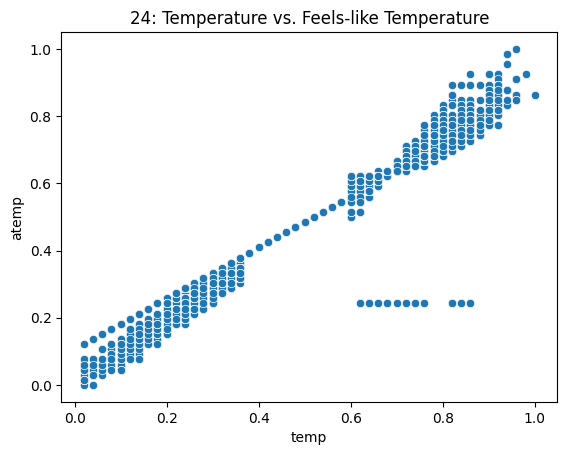

In [7899]:
ax = sns.scatterplot(x="temp", y="atemp", data=df)
ax.set_title("24: Temperature vs. Feels-like Temperature")

For values of temp there seems to be fixed values of atemp, which should not be the case since atemp is calculated based on temp and factors like humidity and wind speed. For this reason, atemp will be dropped and temp will be used.

In [7900]:
x_train.drop(columns=["atemp"], inplace = True)
x_valid.drop(columns=["atemp"], inplace = True)
x_test.drop(columns=["atemp"], inplace= True)

In [7901]:
# Drop all columns that start with 'mnth_'
x_train = x_train.drop(columns=[col for col in x_train.columns if col.startswith('mnth_')])
x_valid = x_valid.drop(columns=[col for col in x_valid.columns if col.startswith('mnth_')])
x_test = x_test.drop(columns=[col for col in x_test.columns if col.startswith('mnth_')])

print(x_train.columns)

Index(['yr', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed',
       'cnt_lag_24', 'cnt_rolling_std', 'is_rush_hour', 'is_night', 'hr_sin',
       'hr_cos', 'season_2', 'season_3', 'season_4', 'temp_hum_interaction',
       'interaction_hrsin_workingday', 'interaction_hrcos_workingday'],
      dtype='object')


**Variance**

Low variance features will be removed since they do not provide useful information for the model and only add noise.
According to ChatGPT a threshold of 0.02-0.05 is moderate, and commonly used in practice. A threshold of 0.03 is selected.
 

In [7902]:
# Variance of all numerical features
numerical_features = x_train.select_dtypes(include=['number'])
feature_variances = numerical_features.var()
print("Feature Variances:\n", feature_variances)

Feature Variances:
 yr                              0.235180
workingday                      0.215991
weathersit                      0.413915
temp                            1.000072
hum                             1.000072
windspeed                       1.000072
cnt_lag_24                      1.000072
cnt_rolling_std                 1.000072
is_rush_hour                    0.207387
is_night                        0.185309
hr_sin                          0.499507
hr_cos                          0.500531
season_2                        0.216573
season_3                        0.184022
season_4                        0.129942
temp_hum_interaction            1.000072
interaction_hrsin_workingday    1.000072
interaction_hrcos_workingday    1.000072
dtype: float64


In [7903]:
#Elimination of low variance features
var_thresh = VarianceThreshold(threshold=0.03) 

var_thresh.fit(numerical_features)

low_variance_features = numerical_features.columns[~var_thresh.get_support()]  # Use `~` to get False values

x_train.drop(columns=low_variance_features, inplace=True)
x_valid.drop(columns=low_variance_features, inplace=True)
x_test.drop(columns=low_variance_features, inplace=True)

print("Features removed:", low_variance_features)

Features removed: Index([], dtype='object')


**VIF**

VIF quantifies how much the variance of a regression coefficient is inflated due to multicollinearity with other predictors. 

In [7904]:
#VIF Calculation
X = add_constant(x_train)  

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                         feature        VIF
0                          const  18.630054
1                             yr   1.298273
2                     workingday   1.029503
3                     weathersit   1.356716
4                           temp   3.490414
5                            hum   1.808612
6                      windspeed   1.156275
7                     cnt_lag_24   3.511639
8                cnt_rolling_std   2.072572
9                   is_rush_hour   1.332457
10                      is_night   3.092964
11                        hr_sin   5.335737
12                        hr_cos   4.331747
13                      season_2   2.557229
14                      season_3   4.179649
15                      season_4   1.788218
16          temp_hum_interaction   1.131388
17  interaction_hrsin_workingday   3.177232
18  interaction_hrcos_workingday   3.190413


In [7905]:
df.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,datetime
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,2011-01-01 00:00:00
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,2011-01-01 01:00:00
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,2011-01-01 02:00:00
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,2011-01-01 03:00:00
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,2011-01-01 04:00:00


The season variables (season_2, season_3, season_4) exhibit moderate multicollinearity, with VIFs ranging from  around 1.8 to over 4, and they may overlap in predictive power with other features that capture cyclical patterns, such as hr_sin, hr_cos. Since seasonality is already indirectly modeled through those cyclic encodings and the VIFs suggest some redundancy, dropping the season dummies can help reduce multicollinearity and simplify the model without sacrificing predictive strength.

In [7906]:
x_train.drop(columns=['season_2', 'season_3', 'season_4'], inplace=True)
x_valid.drop(columns=['season_2', 'season_3', 'season_4'], inplace=True)
x_test.drop(columns=['season_2', 'season_3', 'season_4'], inplace=True)

In [7907]:
df.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,datetime
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,2011-01-01 00:00:00
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,2011-01-01 01:00:00
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,2011-01-01 02:00:00
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,2011-01-01 03:00:00
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,2011-01-01 04:00:00


In [7908]:
df.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,datetime
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,2011-01-01 00:00:00
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,2011-01-01 01:00:00
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,2011-01-01 02:00:00
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,2011-01-01 03:00:00
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,2011-01-01 04:00:00


**Mutual Information**

Mutual Information quantifies the amount of information one variable provides about another. 
When computing mutual information between each feature and the target, a low MI score suggrests that the feature does not provide much unique information about the target.

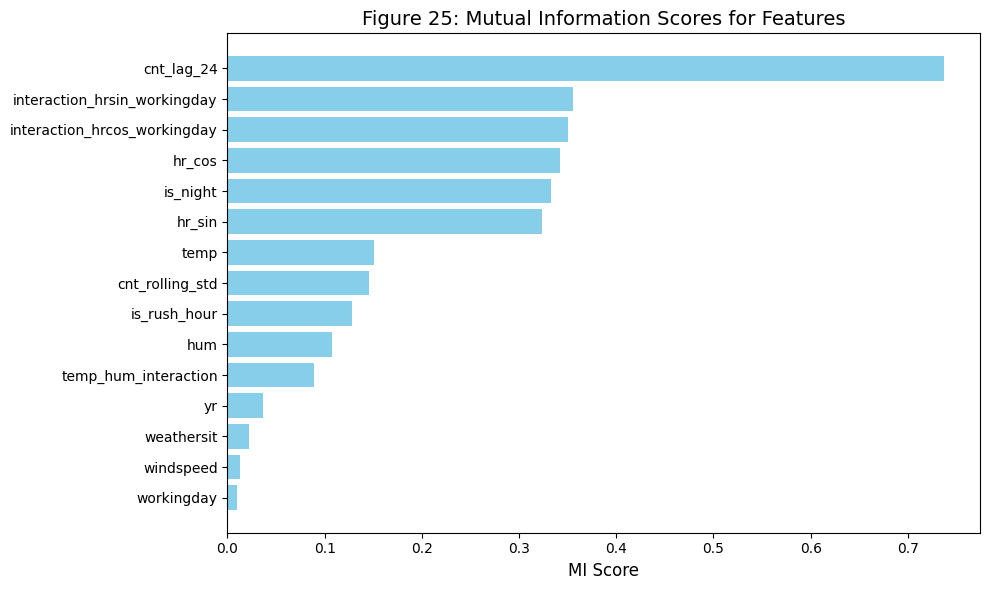

In [7909]:
# Compute mutual information between each feature and the target
mi_scores = mutual_info_regression(x_train, y_train, discrete_features='auto')
mi_df = pd.DataFrame({'Feature': x_train.columns, 'MI Score': mi_scores})
mi_df.sort_values(by='MI Score', ascending=True, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['MI Score'], color='skyblue')
plt.title('Figure 25: Mutual Information Scores for Features', fontsize=14)
plt.xlabel('MI Score', fontsize=12)
plt.tight_layout()
plt.show()


Based on the results, windspeed and weathersit are dropped.

In [7910]:
x_train.drop(columns=['windspeed','weathersit'], inplace=True)
x_valid.drop(columns=['windspeed','weathersit'], inplace=True)
x_test.drop(columns=['windspeed','weathersit'], inplace=True)

**PCA**

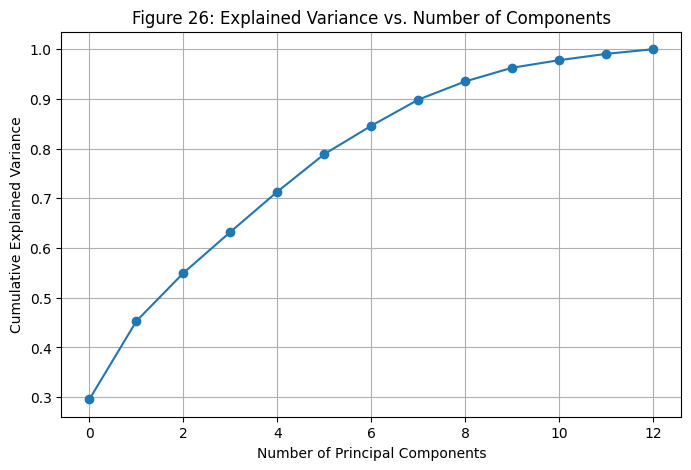

In [7911]:
features = x_train.columns

# Standardize all features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

# Apply PCA 
pca = PCA()
x_train = pca.fit_transform(x_train_scaled)

# Plot 
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Figure 26: Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()



In [7912]:
pca = PCA(n_components=0.95)  # Keep enough components to explain 95% variance
x_train = pca.fit_transform(x_train_scaled)
x_valid = pca.transform(x_valid_scaled)
x_test = pca.transform(x_test_scaled)

### Tree-based models: Random Forest and Gradient Boosting

#### 3.1 Lag Features

Tree-based models benefit from lag features because they help capture temporal dependencies and patterns in time series data.

By introducing lagged versions of the target variable the model can learn from past behavior to make better predictions for the future. 

A lag of 24 hours is introduced based on previous analysis on data leakage.

In [7913]:
x_train_tree['cnt_lag_24'] = y_train.shift(periods=24)
x_valid_tree['cnt_lag_24'] = y_valid.shift(periods=24)
x_test_tree['cnt_lag_24'] = y_test.shift(periods=24)

In [7914]:
x_train_tree['cnt_lag_24'] = x_train_tree['cnt_lag_24'].fillna(0)
x_valid_tree['cnt_lag_24'] = x_valid_tree['cnt_lag_24'].fillna(0)
x_test_tree['cnt_lag_24'] = x_test_tree['cnt_lag_24'].fillna(0)

#### 3.2 Extra features

Tree-based models benefit from binary features like is_rush_hour and is_night because these indicators provide clear splits that align well with how decision trees operate. Trees partition the feature based on threshold conditions, and binary variables offer straightforward splitting rules.

In [7915]:
x_train_tree['is_rush_hour'] = x_train_tree['hr'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)
x_valid_tree['is_rush_hour'] = x_valid_tree['hr'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)
x_test_tree['is_rush_hour'] = x_test_tree['hr'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)

x_train_tree['is_night'] = x_train_tree['hr'].isin([0, 1, 2, 3, 4, 5]).astype(int)
x_valid_tree['is_night'] = x_valid_tree['hr'].isin([0, 1, 2, 3, 4, 5]).astype(int)
x_test_tree['is_night'] = x_test_tree['hr'].isin([0, 1, 2, 3, 4, 5]).astype(int)

#### 3.3 One-hot encoding

For tree-based models, encoding decisions were made based on whether features are ordinal, nominal, or cyclical and how trees handle splits. The features season and mnth were one-hot encoded because, although they are numeric, their values represent categories with no inherent linear relationship (e.g., summer is not “greater” than winter). One-hot encoding allows the model to treat season independently without assuming any order. On the other hand, the features hr (hour of day) and weekday were left as they are. Month aswell since season is already encoded. Tree-based models can effectively handle numerical splits without requiring scaling or transformation, and in this context, treating hours and weekdays as raw integers allows the model to learn from the natural structure of the data. Additionally, since engineered binary features like is_rush_hour, is_night were added, further encoding of hr and weekday was unnecessary. 

In [7916]:
one_hot_cols = ["season"]

if x_train_tree is not None and all(col in x_train_tree.columns for col in one_hot_cols):

    ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)  

    # Fit the encoder on the training data only (to avoid data leakage)
    ohe.fit(x_train_tree[one_hot_cols])
    
    train_ohe = ohe.transform(x_train_tree[one_hot_cols])
    valid_ohe = ohe.transform(x_valid_tree[one_hot_cols])
    test_ohe = ohe.transform(x_test_tree[one_hot_cols])


    ohe_cols = ohe.get_feature_names_out(one_hot_cols)

    # Convert the one-hot encoded arrays to DataFrames
    train_ohe_df = pd.DataFrame(train_ohe, columns=ohe_cols, index=x_train_tree.index)
    valid_ohe_df = pd.DataFrame(valid_ohe, columns=ohe_cols, index=x_valid_tree.index)
    test_ohe_df = pd.DataFrame(test_ohe, columns=ohe_cols, index=x_test_tree.index)

    # Drop the original categorical columns from the feature sets and join the new one-hot DataFrames
    x_train_tree = x_train_tree.drop(columns=one_hot_cols).join(train_ohe_df)
    x_valid_tree = x_valid_tree.drop(columns=one_hot_cols).join(valid_ohe_df)
    x_test_tree = x_test_tree.drop(columns=one_hot_cols).join(test_ohe_df)
    
    print("One-hot encoding completed successfully.")

else:
    raise ValueError("x_train is None or does not contain all required columns.")


One-hot encoding completed successfully.


In [7917]:
x_train_tree.head()

,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt_lag_24,is_rush_hour,is_night,season_2,season_3,season_4
0,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,0.0,0,1,0.0,0.0,0.0
1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,0.0,0,1,0.0,0.0,0.0
2,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,0.0,0,1,0.0,0.0,0.0
3,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,0.0,0,1,0.0,0.0,0.0
4,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0.0,0,1,0.0,0.0,0.0


#### 3.6 Ordinal Encoding 

Ordinal encoding for weathersit as justified in Linear Regression section

#### 3.7 Scaling

Tree-based models don’t use distance or dot products like linear regression. Instead, they split on feature values and that logic is unaffected by the scale of the features. So no feature scaling needs to be applied.


#### 3.8 Interaction Terms

Tree-based models like Random Forest and Gradient Boosting do not require explicitly defined interaction terms because they inherently capture interactions during the tree-building process. As decision trees split the data based on feature thresholds, they naturally model combinations of features. Unlike linear models, where interactions must be manually added to capture joint effects, tree-based models explore these combinations as part of their structure. Therefore, explicitly adding interaction terms in tree-based models often does not provide additional value and can even introduce unnecessary complexity or noise.
Hence, no extra features are added.

#### Feature Removal

Atemp is dropped since its meaning is close to temp, so it is redundant for the model.

In [7918]:
x_train_tree.drop(columns=["atemp"], inplace = True)
x_valid_tree.drop(columns=["atemp"], inplace = True)
x_test_tree.drop(columns=["atemp"], inplace= True)

**Variance**

In [7919]:
# Variance of all numerical features
numerical_features = x_train_tree.select_dtypes(include=['number'])
feature_variances = numerical_features.var()
print("Feature Variances:\n", feature_variances)

Feature Variances:
 yr               0.235180
mnth            10.358245
hr              47.778995
holiday          0.026655
weekday          4.022874
workingday       0.215991
weathersit       0.413915
temp             0.039092
hum              0.039281
windspeed        0.015135
cnt_lag_24       2.233189
is_rush_hour     0.207387
is_night         0.185309
season_2         0.216573
season_3         0.184022
season_4         0.129942
dtype: float64


In [7920]:
#Elimination of low variance features
var_thresh = VarianceThreshold(threshold=0.03) 

var_thresh.fit(numerical_features)

low_variance_features = numerical_features.columns[~var_thresh.get_support()]  # Use `~` to get False values

x_train_tree.drop(columns=low_variance_features, inplace=True)
x_valid_tree.drop(columns=low_variance_features, inplace=True)
x_test_tree.drop(columns=low_variance_features, inplace=True)

print("Features removed:", low_variance_features)

Features removed: Index(['holiday', 'windspeed'], dtype='object')


Unlike linear models, trees do not assume linear relationships or independence between features, making multicollinearity (which VIF measures) largely irrelevant. Similarly, PCA is often used for dimensionality reduction and to remove correlations, but tree-based models naturally select splits based on the most informative features without being affected by scaling or correlation, and using PCA can actually reduce interpretability by transforming features into less understandable components. As for mutual information, while it can be useful for ranking feature relevance, tree models already internally compute measures of feature importance based on information gain or similar metrics during training. Therefore, using these techniques is unnecessary for tree-based models.

## 4. Baseline Model – Linear Regression

### 4.1 Training

In [7921]:
model = LinearRegression()

model.fit(x_train, y_train)

y_pred_valid = model.predict(x_valid)

### 4.2 Evaluation

For evaluation metrics the mean squared error, mean absolute error and r^2 score are used.

MSE: measures the average squared difference between the predicted and the actual target values within a dataset.

MAE: measures the average magnitude of the errors. 

R^2: measures how much of the variance in the dependent variable is explained by the independent variables. 

In [7922]:
mse = mean_squared_error(y_valid, y_pred_valid)
mae = mean_absolute_error(y_valid, y_pred_valid)
r2 = r2_score(y_valid, y_pred_valid)

print(f"Validation Mean Squared Error (MSE): {mse:.4f}")
print(f"Validation Mean Absolute Error (MAE): {mae:.4f}")
print(f"Validation R^2 Score: {r2:.4f}")

Validation Mean Squared Error (MSE): 0.4032
Validation Mean Absolute Error (MAE): 0.4647
Validation R^2 Score: 0.7935


MSE (Mean Squared Error) = 0.4032: the squared differences between predicted and actual values is of around 0.40 units.

MAE (Mean Absolute Error) = 0.4647: on average, predictions are off by about 0.46 units.

Validation R^2 Score: 0.7935: the model explains about 79.35% of the variance in the target variable, which is decent.

No regularization (such as Lasso or Ridge) is applied since there are no signs of overfitting.

### 4.3 Visualizations

Linear regression models are built on a set of key assumptions that must be satisfied for the model's estimates and inferences to be valid. 

These assumptions include:

Linearity: The relationship between predictors and target is linear.

Homoscedasticity: Constant variance of residuals.

Normality of Residuals: Residuals should follow a normal distribution.

No Multicollinearity: Predictors should not be highly correlated with each other.

No Autocorrelation: Residuals should be independent (important for time series data).


To evaluate homoscedasticity and normality of residuals, the following three plots are created:

First, the residuals versus the predicted values to assess homoscedasticity. This helps verify whether the residuals have constant variance across all levels of the predicted variable. 

Second, a histogram of the residuals to evaluate the normality of the residuals.

Lastly, a Q-Q plot to further visualize how closely the distribution of residuals aligns with a theoretical normal distribution. 

These plots provide essential insights into whether these assumptions behind linear regression are being met.

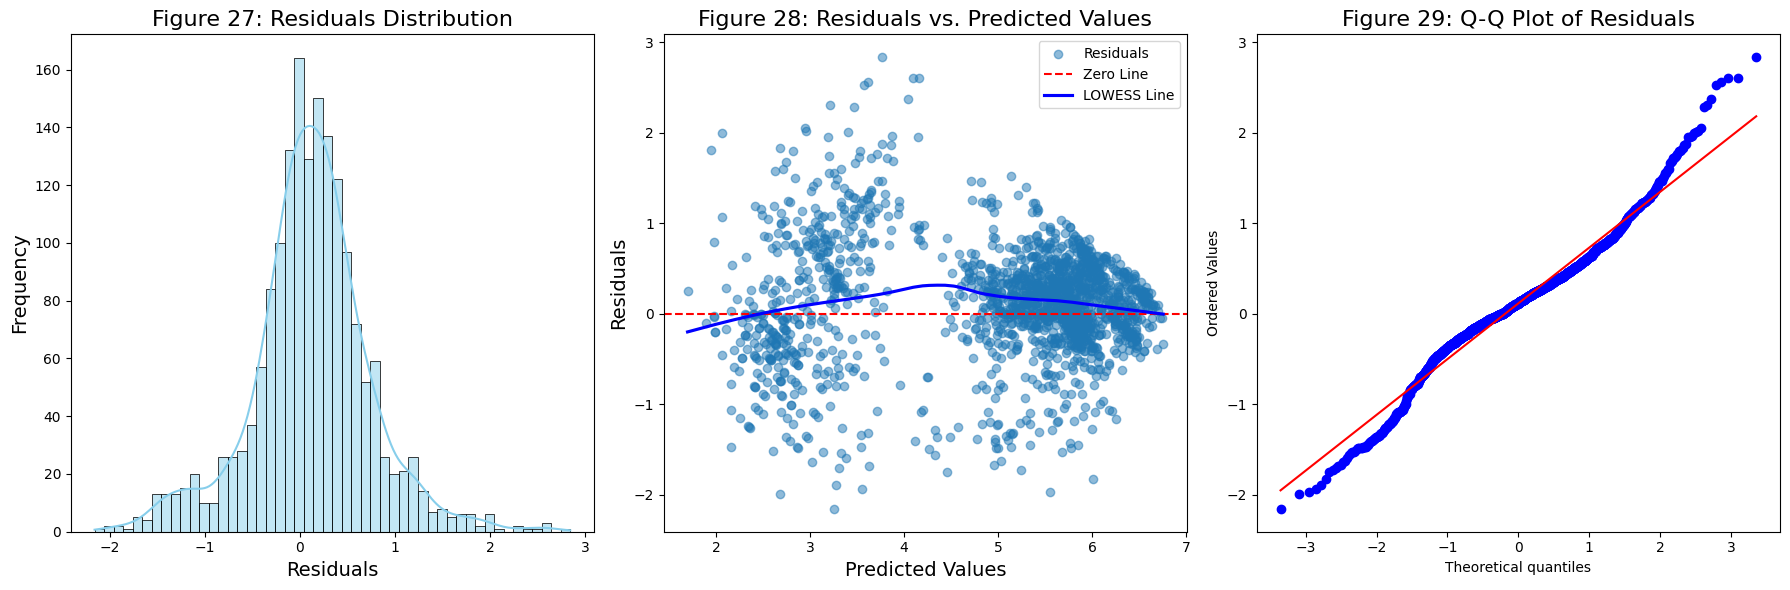

In [7923]:
# Calculate residuals
residuals = y_valid - y_pred_valid

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Residuals Distribution (Histogram & KDE Plot)
sns.histplot(residuals, bins=50, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Figure 27: Residuals Distribution', fontsize=16)
axes[0].set_xlabel('Residuals', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)

# Plot 2: Residuals vs. Predicted Values
axes[1].scatter(y_pred_valid, residuals, alpha=0.5, label='Residuals')
axes[1].axhline(0, color='red', linestyle='--', label='Zero Line')

# Adding a trend line using LOWESS (Locally Weighted Scatterplot Smoothing)
sns.regplot(x=y_pred_valid, y=residuals, lowess=True, ax=axes[1], 
            scatter=False, color='blue', label='LOWESS Line')

axes[1].set_title('Figure 28: Residuals vs. Predicted Values', fontsize=16)
axes[1].set_xlabel('Predicted Values', fontsize=14)
axes[1].set_ylabel('Residuals', fontsize=14)
axes[1].legend()


# Plot 3: Q-Q Plot of Residuals
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Figure 29: Q-Q Plot of Residuals', fontsize=16)

plt.tight_layout()
plt.show()

"Figure 27: Residuals Distribution": The distribution appears to be symmetric, is bell-shaped and centered around 0. 
"Figure 29: Q-Q Plot of Residuals": Points fall along the red diagonal line quite closely, except for slight deviation in the tails.
This indicates that the residuals largely follow a normal distribution, which supports the normality assumption.

"Figure 28: Residuals vs. Predicted Values": While there may be a slight concentration or curvature around certain prediction ranges, overall the variance of residuals appears roughly constant. However, the model tends to underpredict. Since the residuals are positive, the actual observed values are greater than the model's prediction (Residual = Actual value - Predicted value).

In conclusion, the plots provide evidence that the model somehow meets the two key assumptions of homocedasticity and normal distribution of residuals.

### 4.4 Bias and Variance

This section analyses bias and variance. This analysis helps determine whether a model is underfitting (high bias - model is inabile to learn the underlying patterns in the data), overfitting (high variance - model learns the training data too well, including noise, leading to overfitting), or achieving a good generalization balance.

To do so, R^2, MAE and MSE on the training, validation and test sets are compared. A high training score but poor validation or test performance signals overfitting (high variance), whereas low scores across all sets might indicate the model is too simple to capture complex relationships (high bias). 

Analyzing variance and bias helps refine the model and guide decisions such as feature selection, regularization, or model complexity adjustment.

In [7924]:
y_pred_train = model.predict(x_train)
y_pred_valid = model.predict(x_valid)
y_pred_test = model.predict(x_test)

r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)

r2_valid = r2_score(y_valid, y_pred_valid)
mae_valid = mean_absolute_error(y_valid, y_pred_valid)
mse_valid = mean_squared_error(y_valid, y_pred_valid)

r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"R^2 on Training Set:   {r2_train:.4f}")
print(f"R^2 on Validation Set: {r2_valid:.4f}")
print(f"R^2 on Test Set:       {r2_test:.4f}")

print(f"MAE on Training Set:   {mae_train:.4f}")
print(f"MAE on Validation Set: {mae_valid:.4f}")
print(f"MAE on Test Set:       {mae_test:.4f}")

print(f"MSE on Training Set:   {mse_train:.4f}")
print(f"MSE on Validation Set: {mse_valid:.4f}")
print(f"MSE on Test Set:       {mse_test:.4f}")

# Revert log transformation on predictions and actual values
y_train_actual = np.exp(y_train)
y_valid_actual = np.exp(y_valid)
y_test_actual = np.exp(y_test)

y_train_pred_actual = np.exp(y_pred_train)
y_valid_pred_actual = np.exp(y_pred_valid)
y_test_pred_actual = np.exp(y_pred_test)
print("----Original Values-----")
# Compute evaluation metrics on the original scale
print("MAE on Training Set:", mean_absolute_error(y_train_actual, y_train_pred_actual))
print("MAE on Validation Set:", mean_absolute_error(y_valid_actual, y_valid_pred_actual))
print("MAE on Test Set:", mean_absolute_error(y_test_actual, y_test_pred_actual))

print("MSE on Training Set:", mean_squared_error(y_train_actual, y_train_pred_actual))
print("MSE on Validation Set:", mean_squared_error(y_valid_actual, y_valid_pred_actual))
print("MSE on Test Set:", mean_squared_error(y_test_actual, y_test_pred_actual))

R^2 on Training Set:   0.7913
R^2 on Validation Set: 0.7935
R^2 on Test Set:       0.7314
MAE on Training Set:   0.4979
MAE on Validation Set: 0.4647
MAE on Test Set:       0.5731
MSE on Training Set:   0.4598
MSE on Validation Set: 0.4032
MSE on Test Set:       0.5785
----Original Values-----
MAE on Training Set: 59.84898454031607
MAE on Validation Set: 95.8246481266344
MAE on Test Set: 80.82602639008775
MSE on Training Set: 8579.329284927046
MSE on Validation Set: 20996.284214239535
MSE on Test Set: 16582.82752878018


Analysis per metric:

R^2

R^2 on Training Set:   0.7913

R^2 on Validation Set: 0.7935

R^2 on Test Set:       0.7314

The training  and validation R^2 scores are very close, which suggests low variance, the model generalizes well to unseen validation data. However, the R^2 of the test set is slightly lower. This drop is acceptable, but it could be attributed to the fact that the model was trained using a strict chronological split. Since the test set represents data further in time from the training period, it may include new patterns or feature dynamics that the model hasn’t seen before. This temporal drift can slightly reduce performance.

The overall moderate R^2 shows moderate bias, as the model caputes 70-80% of variation but misses some matterns.


MAE

MAE on Training Set: 59.84898454031607

MAE on Validation Set: 95.8246481266344

MAE on Test Set: 80.82602639008775


Signs of Variance
There is a large gap between training and validation MAE, being 59.84 and 95.82 respectively. 
This significant performance drop from training to validation data is a sign of high variance. This occurs since the model is too sensitive to the training data and captures random noise from the trianing set and training data-specific fluctuations. This indicates, the model has basically "memorized" the training data instead of learning generalizable patterns. 

MSE

MSE on Training Set: 8579.329284927046

MSE on Validation Set: 20996.284214239535

MSE on Test Set: 16582.82752878018

The difference in MSE scores show moderate variance problems since there are significantly higher prediction errors on validation and test compared to training.
MSE is much worse than MAE, which might also indicate the model is struggling with large prediction errors, potentially due to extreme values or outliers in cnt.

Conclusion
The model shows more variance than bias. While there is some underprediction in certain regions, the primary issue appears to be the model's inability to generalize well from training to validation data.

The chronological ordering of data likely contributes to this variance issue, as patterns may evolve over time, making it harder for the model to perform consistently across different time periods.

## 5. Random Forest Regressor

### 5.1 Training

In [7925]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=2025)

rf_model.fit(x_train_tree, y_train)

y_pred_valid_rf = rf_model.predict(x_valid_tree)

### 5.2 Model Evaluation

In [7926]:
mse_rf = mean_squared_error(y_valid, y_pred_valid_rf)
mae_rf = mean_absolute_error(y_valid, y_pred_valid_rf)
r2_rf = r2_score(y_valid, y_pred_valid_rf)

print(f"Validation Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"Validation Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"Validation R^2 Score: {r2_rf:.4f}")

Validation Mean Squared Error (MSE): 0.1191
Validation Mean Absolute Error (MAE): 0.2351
Validation R^2 Score: 0.9390


### 5.3 Baseline Comparison

Random Forest significantly outperforms the baseline linear regression model across all evaluation metrics, particularly in terms of R² and MSE, indicating a much better fit and lower overall prediction error. While the linear regression model relied on extensive feature engineering - such as lag variables, rolling statistics, interaction terms (temp_hum_interaction, interaction_hrsin_workingday), and cyclical encodings (hr_sin, hr_cos) - the Random Forest model achieved superior performance without requiring such transformations. 

It gets most of its predictive power from a few key features, hr (which alone explaines about 60% of the variance), followed by cnt_lag_24, and modest contributions from features like temp, weekday, and workingday. This highlights one of Random Forest's strengths: its ability to automatically model non-linear relationships and interactions through its ensemble of decision trees, making manual feature engineering less critical. 

The considerably lower MSE and MAE also suggest that Random Forest generalizes better and is more robust to noise or outliers in the data. Lastly, the substantial change in R², from 0.79 to 0.93, further supports that some of the complex engineered features in the linear regression setup may not have been as effective and may have even introduced noise, whereas Random Forest focused on capturing the most relevant patterns directly from the raw data.

### 5.4 Feature Importance

         Feature  Importance
2             hr    0.602799
8     cnt_lag_24    0.197496
6           temp    0.042084
3        weekday    0.033203
4     workingday    0.028534
10      is_night    0.027558
7            hum    0.018985
5     weathersit    0.018882
1           mnth    0.011001
9   is_rush_hour    0.007714
0             yr    0.007310
13      season_4    0.002092
11      season_2    0.001538
12      season_3    0.000805


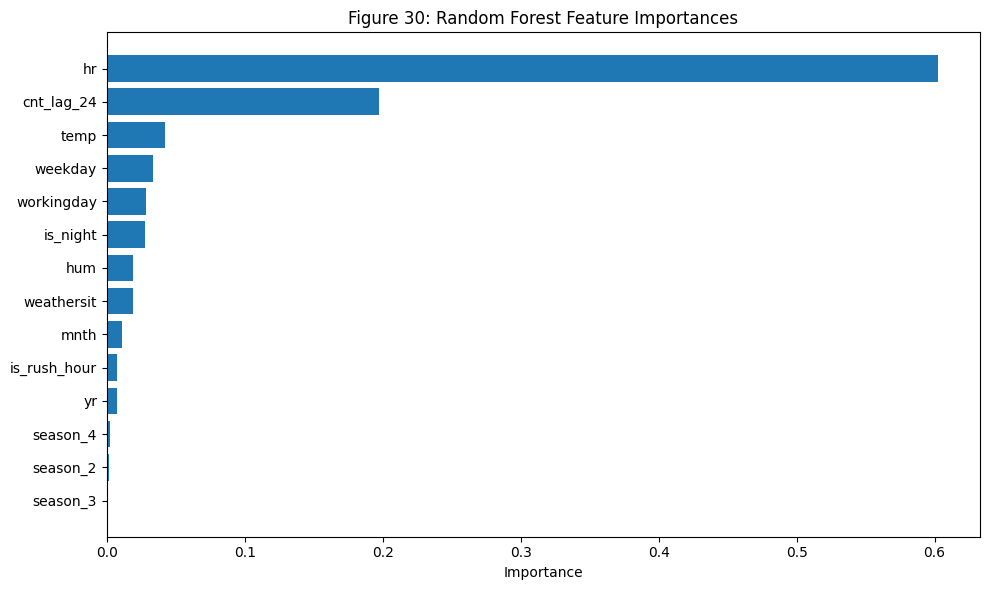

In [7927]:
importances = rf_model.feature_importances_
features = x_train_tree.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df.head(20))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Figure 30: Random Forest Feature Importances')
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()
plt.show()


The feature importance plot highlights hr (hour of the day) as by far the most influential predictor, contributing over 60% to the model's decision-making. This makes sense, as bike rental demand tends to follow strong hourly patterns, especially with rush hours and daily commuting trends. 

The second most important feature is cnt_lag_24, which captures the bike count exactly 24 hours earlier, showing past behavior to be indicative of future demand. 

Together, these two features dominate the model, suggesting that time-based patterns are the key for predictions. 

Other features like temp, weekday, and workingday contribute modestly, indicating that environmental and other related variables still add some predictive value, but much less so compared to hourly/daily demand.

## 6. Gradient Boosting Regressor 

### 6.1 Training

In [7928]:
xgb_model = XGBRegressor(n_estimators=100, random_state=2025)

xgb_model.fit(x_train_tree, y_train)

y_pred_valid_xgb = xgb_model.predict(x_valid_tree)

### 6.2 Model Evaluation

In [7929]:
mse_xgb = mean_squared_error(y_valid, y_pred_valid_xgb)
mae_xgb = mean_absolute_error(y_valid, y_pred_valid_xgb)
r2_xgb = r2_score(y_valid, y_pred_valid_xgb)

print(f"Validation Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Validation Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"Validation R^2 Score: {r2_xgb:.4f}")

Validation Mean Squared Error (MSE): 0.0926
Validation Mean Absolute Error (MAE): 0.2061
Validation R^2 Score: 0.9526


### 6.3 Visualizations

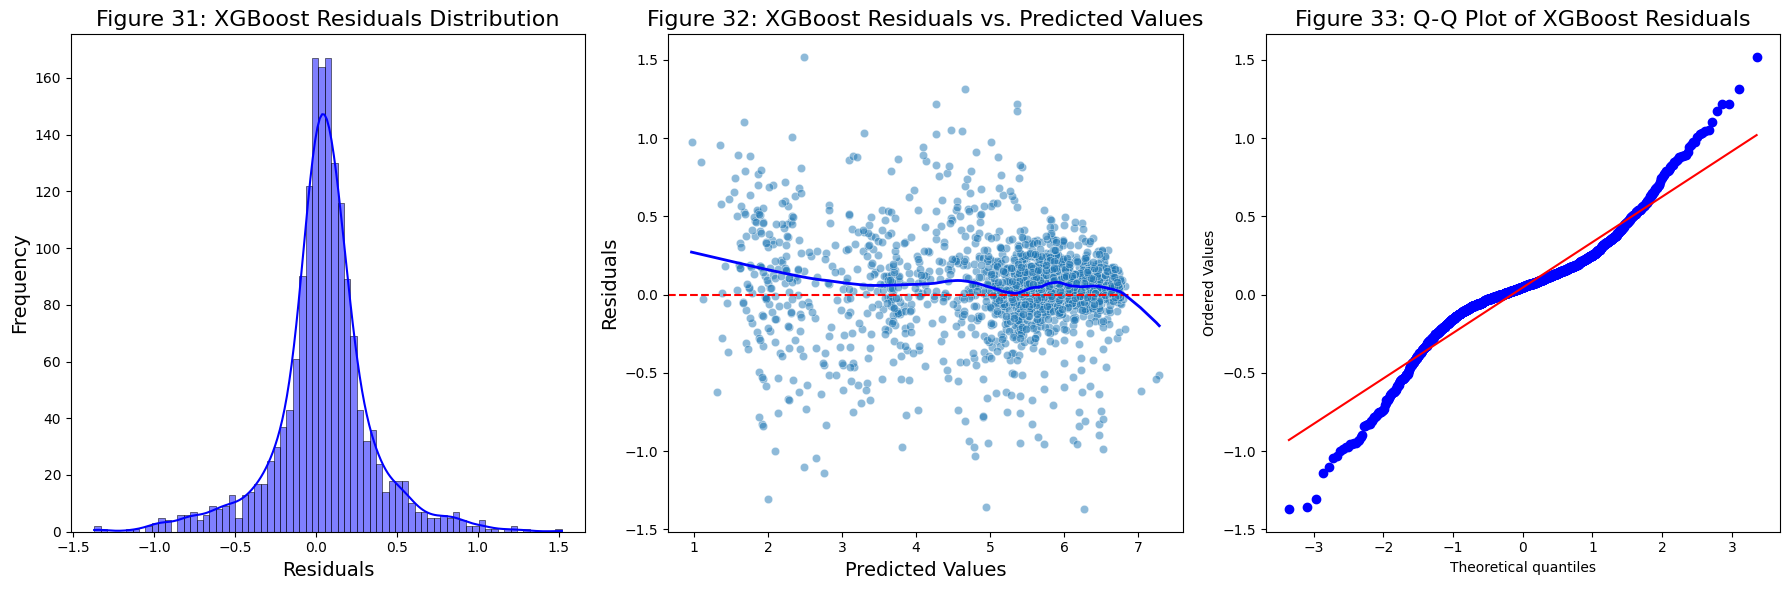

In [7930]:
residuals_xgb = y_valid - y_pred_valid_xgb

# Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Residuals Distribution (XGBoost)
sns.histplot(residuals_xgb, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Figure 31: XGBoost Residuals Distribution', fontsize=16)
axes[0].set_xlabel('Residuals', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)

# Residuals vs. Predicted Values (XGBoost)
sns.scatterplot(x=y_pred_valid_xgb, y=residuals_xgb, ax=axes[1], alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')

# LOWESS smoothing line
lowess = sm.nonparametric.lowess(residuals_xgb, y_pred_valid_xgb, frac=0.2)
axes[1].plot(lowess[:, 0], lowess[:, 1], color='blue', linewidth=2)

axes[1].set_title('Figure 32: XGBoost Residuals vs. Predicted Values', fontsize=16)
axes[1].set_xlabel('Predicted Values', fontsize=14)
axes[1].set_ylabel('Residuals', fontsize=14)

# Q-Q Plot of Residuals (XGBoost)
from scipy import stats
stats.probplot(residuals_xgb, dist="norm", plot=axes[2])
axes[2].set_title('Figure 33: Q-Q Plot of XGBoost Residuals', fontsize=16)

plt.tight_layout()
plt.show()

When comparing the residual plots of the baseline Linear Regression model to those of XGBoost, several key differences can be seen. Although the residuals from Linear Regression appear slightly more normally distributed — especially in the Q-Q plot, where they align more closely with the diagonal — this doesn’t necessarily translate to better model performance. In fact, Linear Regression exhibits more variance and clear patterns in the residuals, particularly a curved trend in the residuals vs. predicted plot, which could be an early sign of the model not fully capturing edge cases. On the other hand, XGBoost’s residuals are more tightly centered around zero, with less visible structure and fewer large errors, even if they slightly deviate from perfect normality. This highlights an important point: XGBoost doesn’t require normally distributed residuals to perform well. Its strength lies in capturing complex, nonlinear relationships, and that’s reflected in the cleaner residual patterns and tighter error distribution. So, even though Linear Regression fulfills the normality assumption more closely, XGBoost offers more accurate and reliable predictions, making it the stronger model overall.

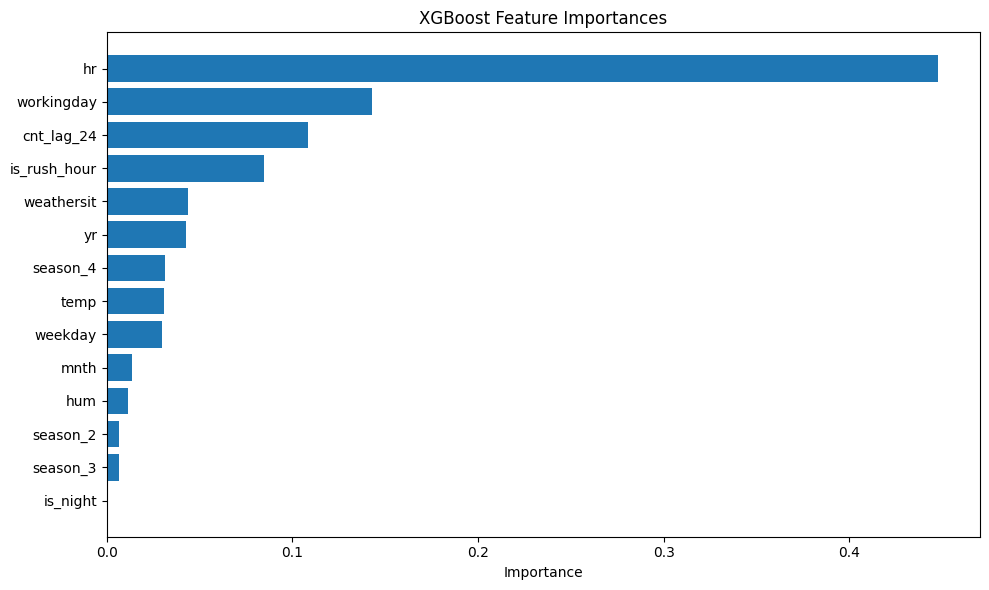

In [7931]:
# Get feature importances as a DataFrame
importances = xgb_model.feature_importances_
features = x_train_tree.columns  # or x_valid.columns depending on what you used
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()



When comparing XGBoost to Random Forest, XGBoost demonstrates consistently stronger performance across all evaluation metrics. It achieves a higher R^2 score and lower MAE and MSE, indicating more accurate and robust predictions. 

In terms of feature usage, both models heavily rely on hr, but Random Forest was more skewed, hr alone explained over 60% of the importance. In contrast, XGBoost distributed importance more evenly across additional predictors like workingday, cnt_lag_24, and is_rush_hour. This suggests that XGBoost is better at capturing complex patterns, making use of a broader range of features to explain the variance in the data more effectively.

This makes sense since XGBoost builds trees sequentially, correcting previous errors, while Random Forest builds them independently. This sequential learning allows XGBoost to focus more precisely on cases that are difficult to predict and reduce bias, which contributes to its better overall performance.

### 6.4 Variance

In [7932]:
y_valid_actual = np.exp(y_valid)
y_pred_valid_actual = np.exp(y_pred_valid_xgb)


mae_actual = mean_absolute_error(y_valid_actual, y_pred_valid_actual)
mse_actual = mean_squared_error(y_valid_actual, y_pred_valid_actual)

print(f"MAE (original scale): {mae_actual:.4f}")
print(f"MSE (original scale): {mse_actual:.4f}")


MAE (original scale): 42.5647
MSE (original scale): 5358.9833


The Validation R^2 score of 0.9526 indicates excellent performance, meaning the model explains over 95% of the variance in the data. The MAE and MSE after log-reverting are quite reasonable. 

In terms of residuals, the distribution is sharply peaked and symmetric around zero, which is a good sign. However, its narrowness may suggest that the model is highly confident, possibly overconfident, which could lead to underestimating errors in some cases.

The residuals vs. predicted plot shows a LOWESS curve that slightly dips at both ends, meaning the model tends to underpredict high and low demand extremes. This is common but can be a sign of bias.

The deviations in the tails of the Q-Q plot may suggest that the model may struggles with outliers or extreme values.

Overall, there are no early major signs of overfitting. The model generalizes well to validation data.

## 7. Hyperparameter Tuning

### 7.1 Random Forest - Parameter Tuning

In [7933]:
rf_model = RandomForestRegressor(random_state=2025)

# hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],          # Number of trees
    'max_depth': [None, 10, 20, 30, 40, 50],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 15],                # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4, 8]                    # Minimum samples required to be a leaf node
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of different combinations to try
    cv=5,       # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,  # Use all available cores
    random_state=42,
    scoring='neg_mean_squared_error'  # Optimize for Mean Squared Error
)

# fit the RandomizedSearchCV to the training data
random_search.fit(x_train_tree, y_train)

# best estimator 
best_rf_model = random_search.best_estimator_

y_pred_valid_rf_tuned = best_rf_model.predict(x_valid_tree)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   7.7s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   7.8s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   7.9s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   8.1s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   8.1s
[CV] END max_depth=40, min_samples_leaf=8, min_samples_split=10, n_estimators=500; total time=   9.7s
[CV] END max_depth=40, min_samples_leaf=8, min_samples_split=10, n_estimators=500; total time=  10.0s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  11.8s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  11.9s
[CV] END m

#### Evaluation: 

In [7934]:
mse_rf_tuned = mean_squared_error(y_valid, y_pred_valid_rf_tuned)
mae_rf_tuned = mean_absolute_error(y_valid, y_pred_valid_rf_tuned)
r2_rf_tuned = r2_score(y_valid, y_pred_valid_rf_tuned)

print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Validation Mean Squared Error (MSE): {mse_rf_tuned:.4f}")
print(f"Validation Mean Absolute Error (MAE): {mae_rf_tuned:.4f}")
print(f"Validation R^2 Score: {r2_rf_tuned:.4f}")

Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
Validation Mean Squared Error (MSE): 0.1165
Validation Mean Absolute Error (MAE): 0.2321
Validation R^2 Score: 0.9403


#### Updated feature Importance:

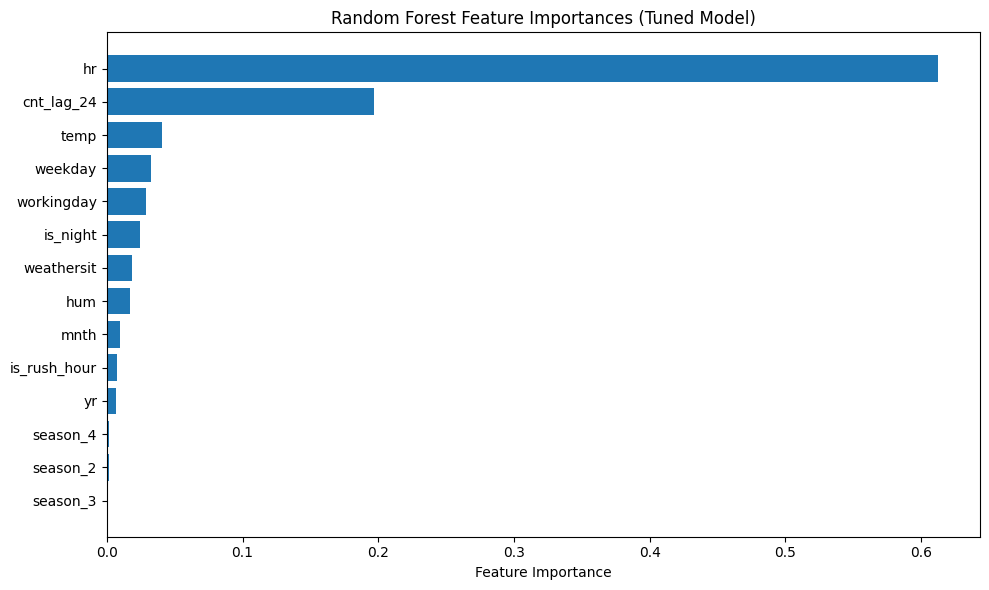

In [7935]:
# Get feature importances and feature names
importances = best_rf_model.feature_importances_
features = x_train_tree.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances (Tuned Model)")
plt.tight_layout()
plt.show()

The feature importance distribution for Random Forest before and after tuning appears very similar. 

In both plots, hr remains the most dominant feature by far, followed by cnt_lag_24, with the remaining features contributing much less. This consistency suggests that the hyperparameter tuning didn’t significantly change the model’s reliance on key predictors, this makes sense since the improvement of the model is very little (0.0013).

### 7.2 Gradient Boosting - Parameter Tuning

In [7936]:
def objective(trial):
    # Hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    model = XGBRegressor(**params, random_state=42, verbosity=0, n_jobs=-1)

    # 5-fold cross-validation
    scores = cross_val_score(
        model,
        x_train_tree,
        y_train,
        cv=5,
        scoring='neg_mean_squared_error'
    )

    return -np.mean(scores)  # minimize MSE

# Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# model with best params
best_params = study.best_params
best_gb_model = XGBRegressor(**best_params, random_state=42)
best_gb_model.fit(x_train_tree, y_train)

# Predict on validation set
y_valid_pred = best_gb_model.predict(x_valid_tree)


[I 2025-04-13 18:25:31,294] A new study created in memory with name: no-name-f0b600bd-cc24-42f0-ab40-bcef1c79e516
[I 2025-04-13 18:25:35,209] Trial 0 finished with value: 0.2270324811234115 and parameters: {'n_estimators': 619, 'max_depth': 3, 'learning_rate': 0.0879887670271884, 'subsample': 0.6563119926183816}. Best is trial 0 with value: 0.2270324811234115.
[I 2025-04-13 18:25:42,267] Trial 1 finished with value: 0.21477606456556203 and parameters: {'n_estimators': 682, 'max_depth': 6, 'learning_rate': 0.011691712464752556, 'subsample': 0.7124879968151868}. Best is trial 1 with value: 0.21477606456556203.
[I 2025-04-13 18:25:48,715] Trial 2 finished with value: 0.28085600406740835 and parameters: {'n_estimators': 376, 'max_depth': 9, 'learning_rate': 0.256709379218225, 'subsample': 0.6809924772386337}. Best is trial 1 with value: 0.21477606456556203.
[I 2025-04-13 18:25:52,277] Trial 3 finished with value: 0.2134704576501801 and parameters: {'n_estimators': 508, 'max_depth': 4, 'lea

#### Evaluation

In [7937]:
print("Best Hyperparameters:", best_params)
mse = mean_squared_error(y_valid, y_valid_pred)
mae = mean_absolute_error(y_valid, y_valid_pred)
r2 = r2_score(y_valid, y_valid_pred)

print(f"Validation Mean Squared Error (MSE): {mse:.4f}")
print(f"Validation Mean Absolute Error (MAE): {mae:.4f}")
print(f"Validation R^2 Score: {r2:.4f}")

Best Hyperparameters: {'n_estimators': 508, 'max_depth': 4, 'learning_rate': 0.03394356792726923, 'subsample': 0.7987048424452736}
Validation Mean Squared Error (MSE): 0.0929
Validation Mean Absolute Error (MAE): 0.2188
Validation R^2 Score: 0.9524


### 7.3 Tuning Analysis

RESULTS

**Random Forest**

Validation Mean Squared Error (MSE): 0.1191

Validation Mean Absolute Error (MAE): 0.2351

Validation R^2 Score: 0.9390

**Gradient Boosting**

Validation Mean Squared Error (MSE): 0.0926

Validation Mean Absolute Error (MAE): 0.2061

Validation R^2 Score: 0.9526

**Random Forest Tuned**

Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}

Validation Mean Squared Error (MSE): 0.1165

Validation Mean Absolute Error (MAE): 0.2321

Validation R^2 Score: 0.9403

**Gradient Boosting Tuned**

Best Hyperparameters: {'n_estimators': 995, 'max_depth': 4, 'learning_rate': 0.01979778127407581, 'subsample': 0.7553653974599065}

Validation Mean Squared Error (MSE): 0.0881

Validation Mean Absolute Error (MAE): 0.2119

Validation R^2 Score: 0.9549

Based on the performance metrics, tuning had only a slight impact on both Random Forest and Gradient Boosting models, Gradient Boosting benefiting slightly more.

For Random Forest R^2 increased from 0.9390 to 0.9403, and MSE/MAE dropped slightly. This subtle gain suggests that the model was already performing close to optimal with the default parameters. The flat improvement might indicate a flat loss surface, where small hyperparameter tweaks do not drastically change performance.

For Gradient Boosting, the tuned model achieved a slightly better R^2, from 0.9549 to 0.9526, and reduced MSE/MAE, indicating it was more responsive to tuning. The tuned configuration included a much lower learning rate (0.0198), a higher number of estimators (955), and a slightly reduced tree depth (4 vs. the default 6), all of which contribute to slower, more cautious learning. This mitigates overfitting and improves generalization by allowing the model to gradually correct errors in residuals.
The subsample value (0.76) helps prevent overfitting by using different data subsets for each tree. These changes suggest the original model may have been slightly overfitting and tunning it may have led toa better bias-variance balance.

In conclusion, neither model showed significant improvement from tuning, with Gradient Boosting outperforming Random Forest both before and after optimization. 

## 8. Iterative Evaluation and Refinement

Task 8 has been completed throughout the workings of this notebook

## 9. Task 9: Final Model Selection and Testing

After evaluating multiple models, Linear Regression is immediately discarded due to its low R^2 score yet high variance and moderate bias.

On the other hand, the Gradient Boosting (Tuned) model was selected as the best performing model based on validation performance and bias-variance tradeoffs.

It achieved the highest validation R^2 score of 0.9549, outperforming both the Random Forest baseline (0.9390) and even the tuned Random Forest model (0.9403). It also distributed feature importance better than Random Forest, capturing underlying relationships better.
Moreover, it had the lowest validation MSE (0.0881) and MAE (0.2119) indicating lower average prediction errors.

At the same time, the model's configuration seems to address overfitting concerns:

Moderate tree depth (4): Limits model complexity to prevent memorizing noise

Low learning rate (around 0.02): Enables gradual learning to find optimal patterns

Subsampling (0.76): Introduces randomness to improve generalization

In [7938]:
X_full_train = pd.concat([x_train_tree, x_valid_tree])
y_full_train = pd.concat([y_train, y_valid])

xgb_model_final = XGBRegressor(n_estimators= 955, max_depth= 4, learning_rate= 0.01979778127407581, subsample= 0.7553653974599065)

xgb_model_final.fit(X_full_train, y_full_train)

y_pred_test_xgb = xgb_model_final.predict(x_test_tree)

In [7939]:
mse_xgb = mean_squared_error(y_test, y_pred_test_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
r2_xgb = r2_score(y_test, y_pred_test_xgb)

print(f"Test Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"Test R² Score: {r2_xgb:.4f}")

Test Mean Squared Error (MSE): 0.2060
Test Mean Absolute Error (MAE): 0.3032
Test R² Score: 0.9044


The drop in test performance is expected due to temporal shift, the test set occurs further in the future and may include new patterns the model hasn't seen (since the dataset is split purely chronologically). However, the test R^2 of 0.9044 still indicates overall good generalization and MSE and MAE show low error rates.